# Analyse exploratoire et features engineering

L'entreprise nous met à disposition plusieurs jeux de données.
Nous allons analyser leurs contenus :  
- Toutes les variables présentes dans les jeux de données ne sont pas forcément pertinentes
- L'utilisation des méthodes de ML nécessitent de tavailler avec des variables numériques
- Il faudra par la suite pouvoir expliquer aux clients pourquoi le crédit est accepté / refusé. Ce qui demande une bonne compréhension des variables en amont.


In [1]:
import pandas as pd
import missingno as msno

In [12]:
application_test = pd.read_csv("application_test.csv")
application_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
#HomeCredit_columns_description = pd.read_csv("HomeCredit_columns_description.csv")
installments_payments = pd.read_csv("installments_payments.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
previous_application = pd.read_csv("previous_application.csv")
sample_submission = pd.read_csv("sample_submission.csv")

Nous avons donc 9 jeux de données à disposition.  
Dans la suite nous allons pour chaque fichier en faire un descriptif, selectionner les variables pertinentes et construire une fonction de préprocessing des variables (création de nouvelles variables, encodage)

Notes : - Les définitions des variables sont indiqués dans le fichier HomeCredit_columns_description.csv
        - Les fonctions de préproccessing proviennent du kerel kaggel https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=86b5173b-d600-4b6d-a056-6d78ead61fa6&bsft_uid=3886902c-a706-48cc-92af-5493d2d046c5&bsft_mid=1e336824-107b-4f30-8699-ee12449f31d2&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=3be9816a-7594-44e2-898b-73334fe5dff9&bsft_mime_type=html&bsft_ek=2022-09-19T11%3A10%3A04Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=10


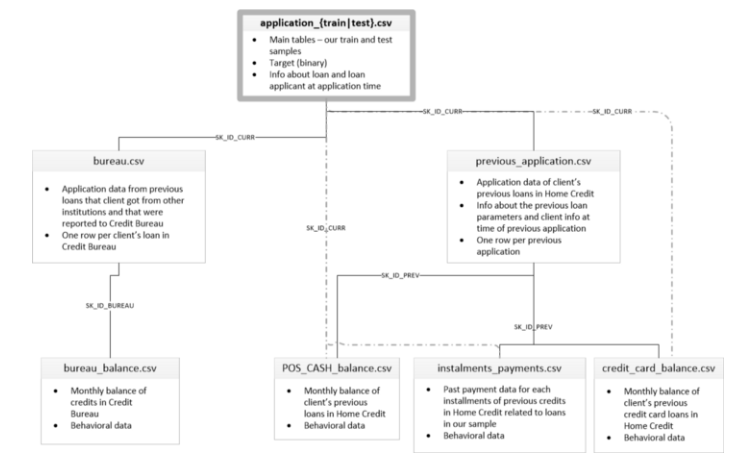

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("Sans titre.png")

## Démarche  
- Analyse des fichier
- Supprimer les variables non pertinentes d'un point de vu métier : Nous allons avoir beaucoup de variables, il sera important de faire un premier écrémage des variables, les définitions sont présentes dans HomeCredit_columns_description.csv
- Encodage des variables catégorielles
- Construction éventuelle des features
- Unification des jeux de données
- Selection des variables les plus pertinentes par corélation
- Remplir les valeurs manquantes

### Définition des fonction d'analyse

Il nous est demandé de mettre à disposition des clients leurs informations personnelles ainsi que leur scrore relatif dans les différentes catégories.   
Ceci afin de justifier l'acceptation ou non du prêt.  
Nous Définissons alors deux fonctions permettant l'analyse des variables quantitatives et catégorielles.

In [36]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    #plotting overall distribution of category
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()
    
    
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()
    
    
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

## Application_test/train

### Description des jeux de données

- Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
- Données statiques pour toutes les demandes de crédit. Une ligne représente un prêt dans notre échantillon de données.

In [37]:
application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [38]:
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [39]:
print(f'Le jeu de données application_test contient {application_test.shape[0]} lignes et {application_test.shape[1]} colonnes') 
print(f'Le jeu de données application_train contient {application_train.shape[0]} lignes et {application_train.shape[1]} colonnes') 

Le jeu de données application_test contient 48744 lignes et 121 colonnes
Le jeu de données application_train contient 307511 lignes et 122 colonnes


### Valeurs manquantes

Le total des Valeurs manquantes est 9152465soit 24.39594190712943 %


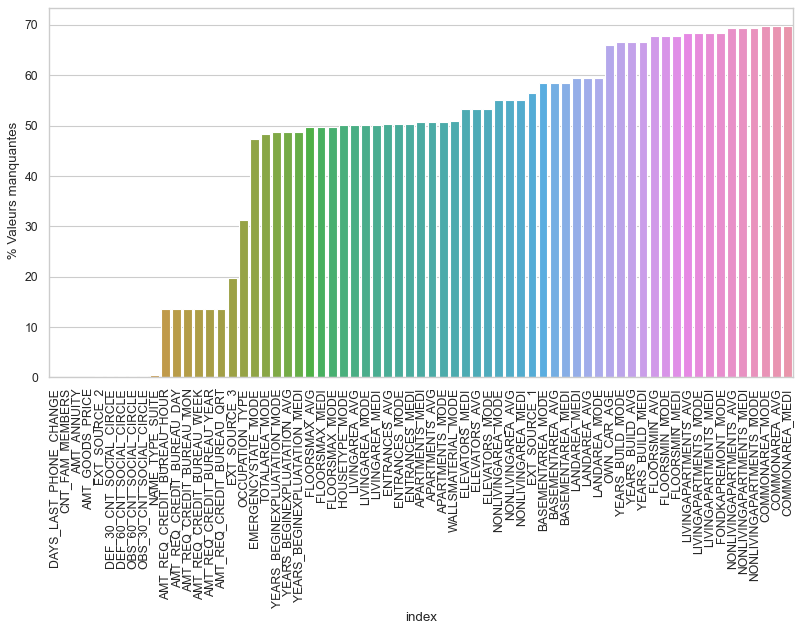

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure


pd.set_option("display.max_rows", None, "display.max_columns", None)

tot_val = application_train.shape[0]*application_train.shape[1]
print(f'Le total des Valeurs manquantes est {application_train.isna().sum().sum()}\
soit {application_train.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(application_train.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = application_train.isna().sum()/application_train.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 90)
plt.show()

Le total des Valeurs manquantes est 1404419soit 23.811686761532336 %


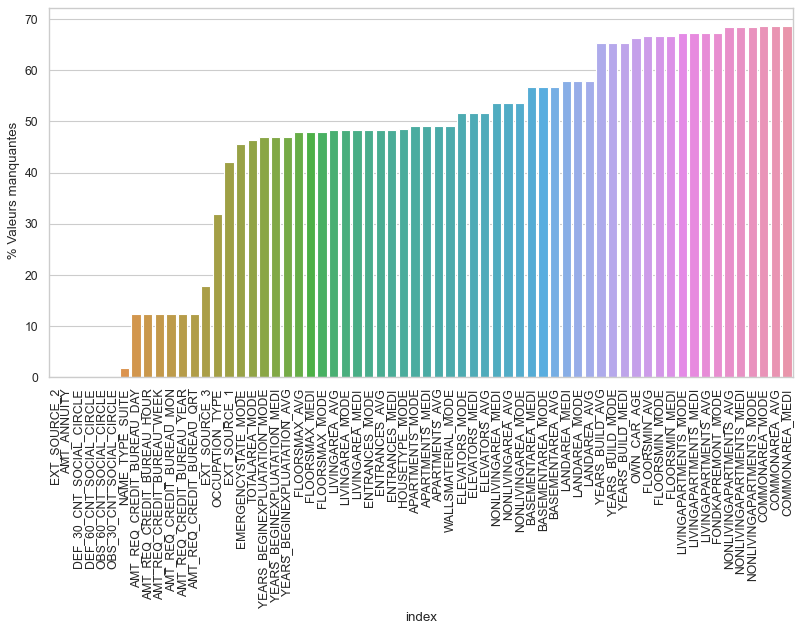

In [41]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

tot_val = application_test.shape[0]*application_test.shape[1]
print(f'Le total des Valeurs manquantes est {application_test.isna().sum().sum()}\
soit {application_test.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(application_test.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = application_test.isna().sum()/application_test.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 90)
plt.show()

### Analyse exploratoire

L'idée est de représenter la distributions des variables debord de manière globale puis ces répartitions dans le groupe des clients ayants fait défault

In [14]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [15]:
24825/(282686+24825)

0.08072881945686496

<AxesSubplot:xlabel='TARGET', ylabel='count'>

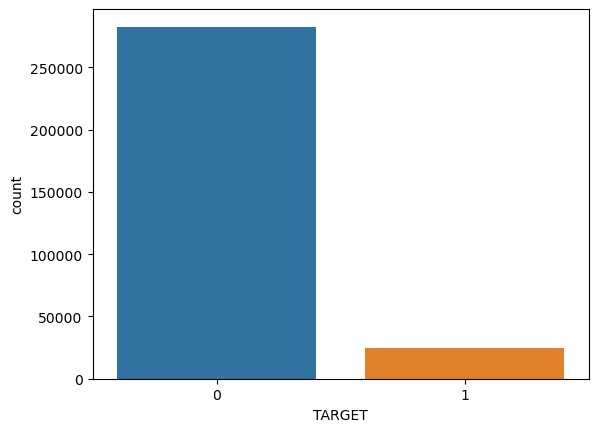

In [16]:
import seaborn as sns

sns.countplot(x='TARGET', data=application_train)

Nous constatons que la répartitions entre la classe 1 est 0 et grandement désequilibrée avec seulement 8% des clients qui ont fait défault

#### Variables catégorielles

Total Number of unique categories of NAME_EDUCATION_TYPE = 5


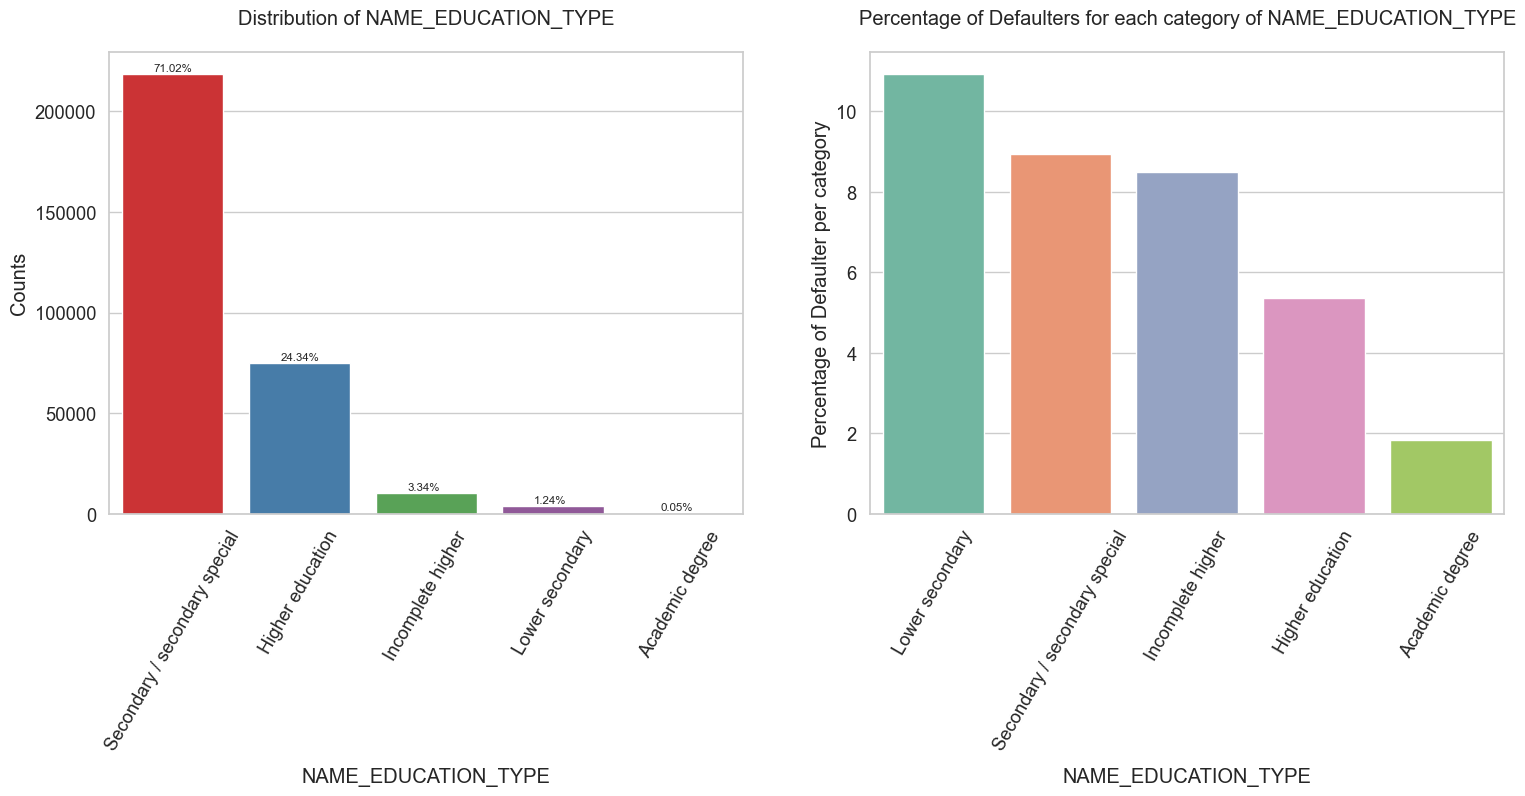

In [42]:
plot_categorical_variables_bar(application_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 60, horizontal_adjust = 0.25) 

Total Number of unique categories of FLAG_OWN_REALTY = 2


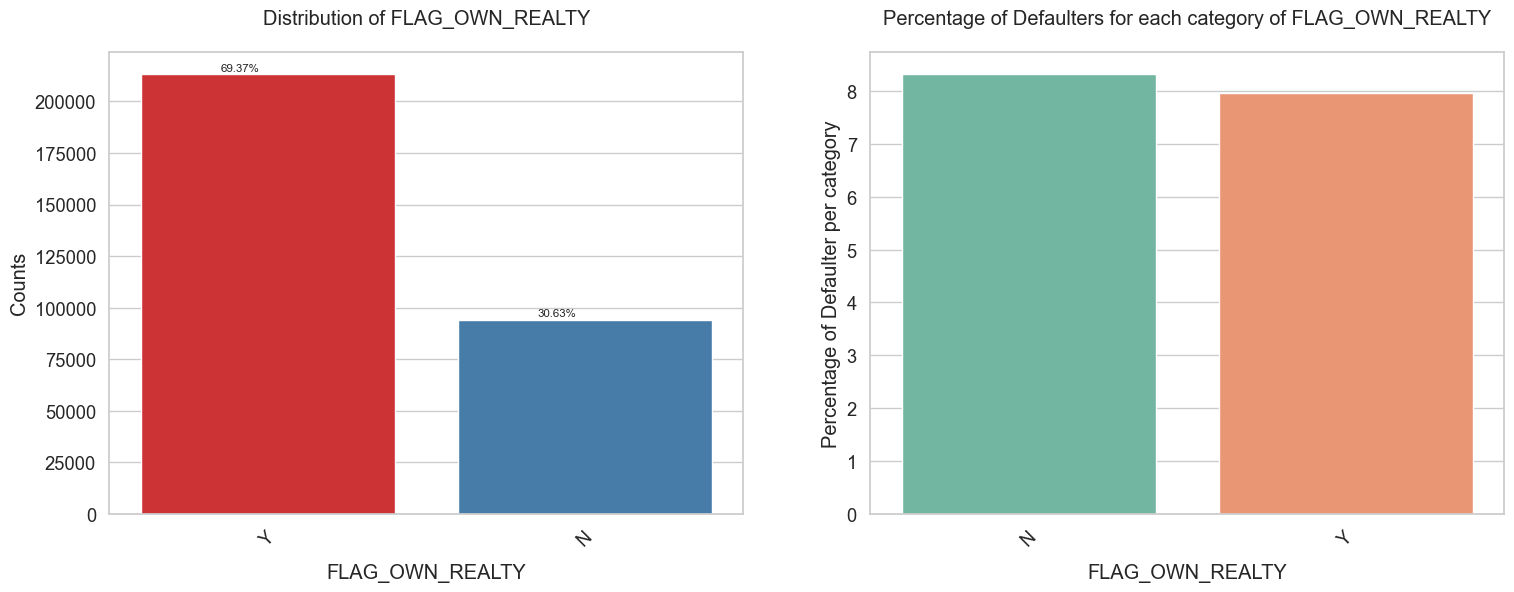

In [43]:
plot_categorical_variables_bar(application_train, column_name = 'FLAG_OWN_REALTY', rotation = 45, horizontal_adjust = 0.25) 

Total Number of unique categories of OCCUPATION_TYPE = 19


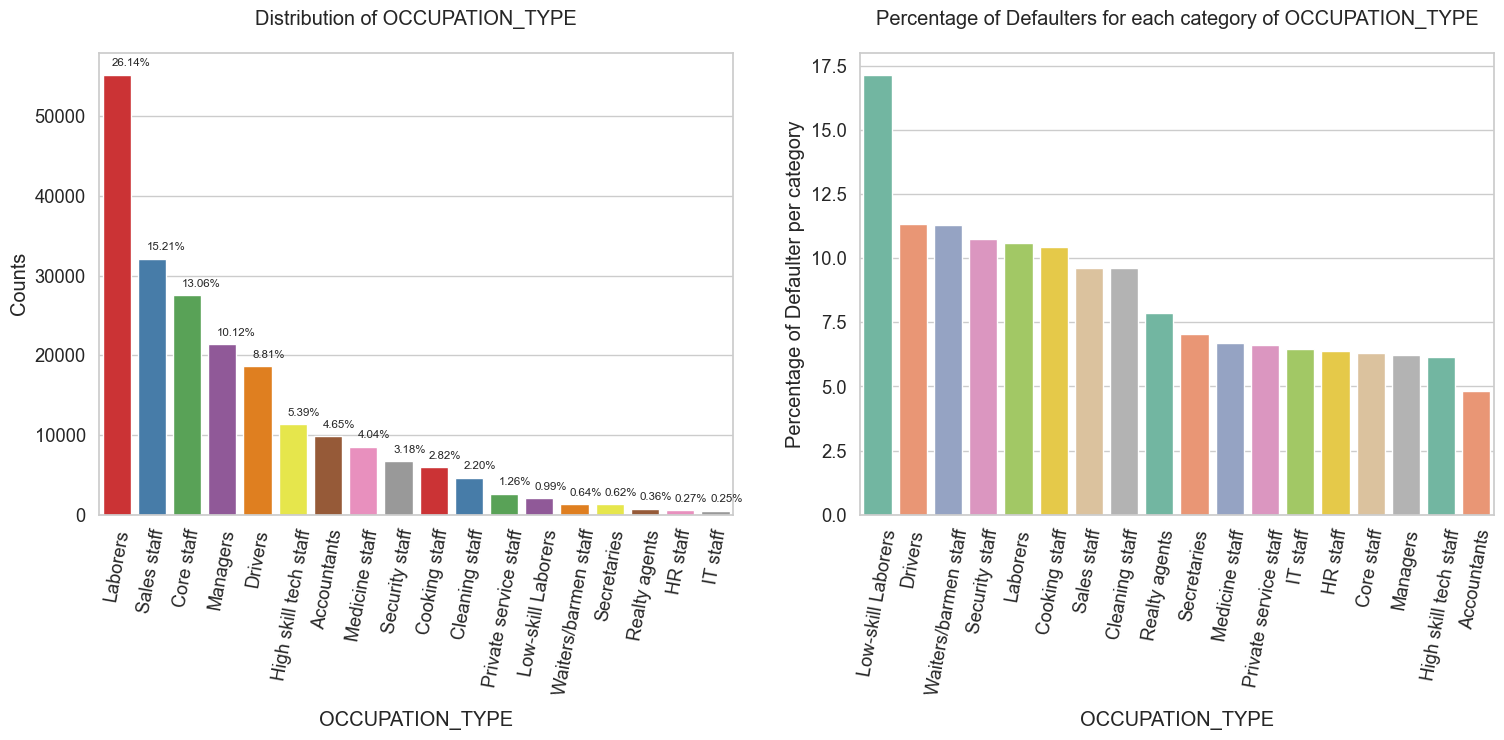

In [44]:
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', rotation = 80, horizontal_adjust = 0.25) 

Total Number of unique categories of ORGANIZATION_TYPE = 58


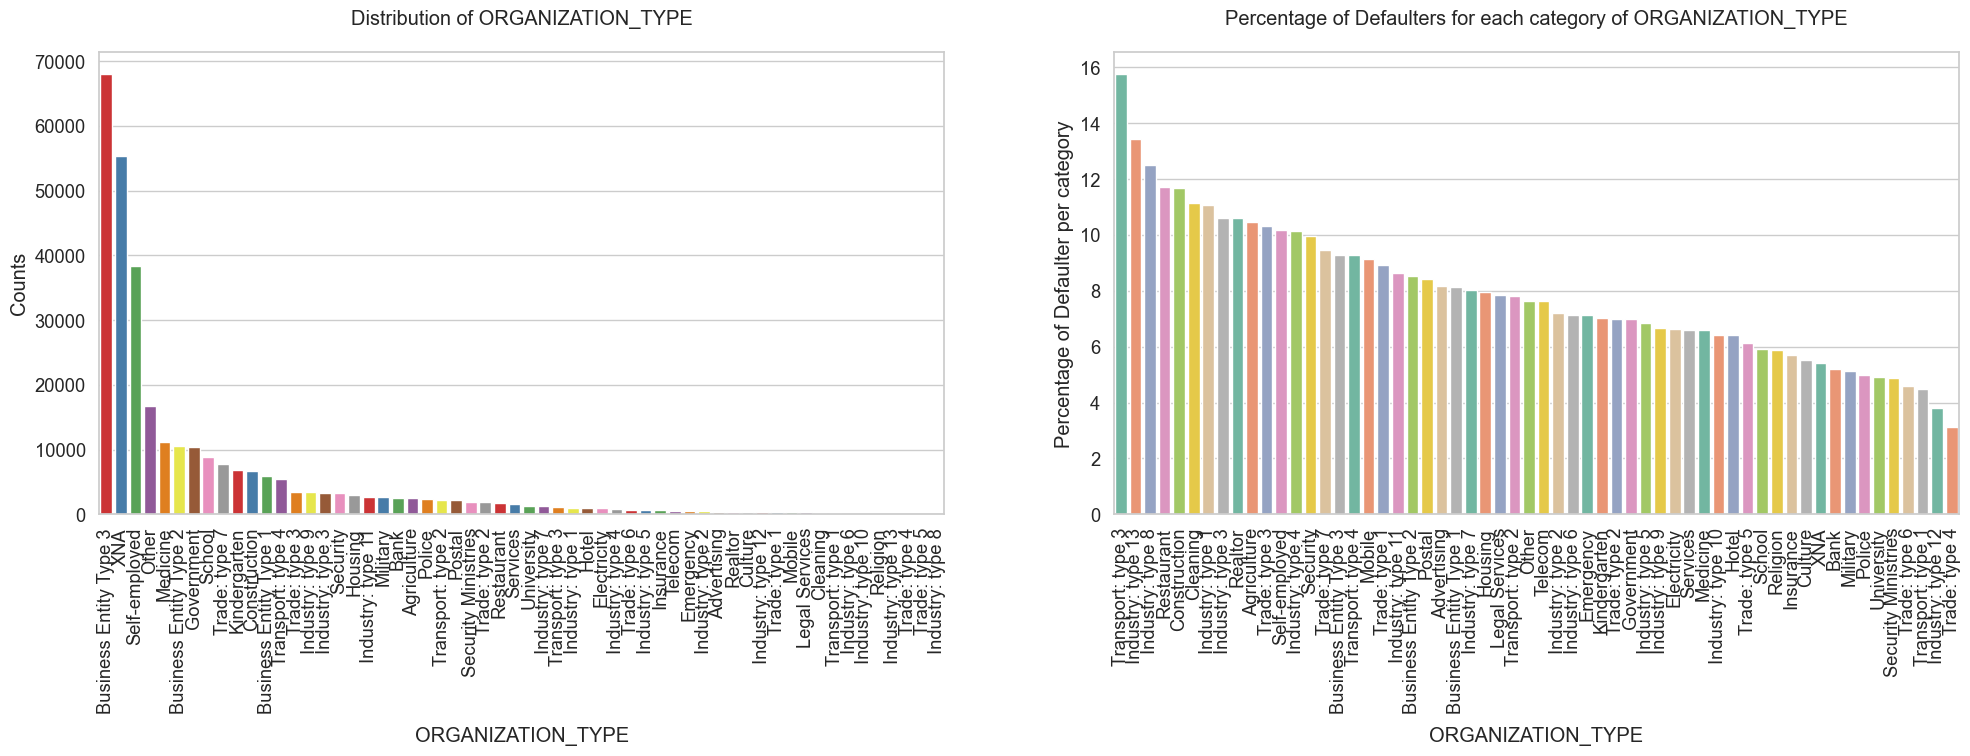

In [45]:
plot_categorical_variables_bar(application_train, column_name = 'ORGANIZATION_TYPE', rotation = 90, horizontal_adjust = 0.25, figsize = (24,6),  percentage_display = False) 

#### Variables numériques

C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


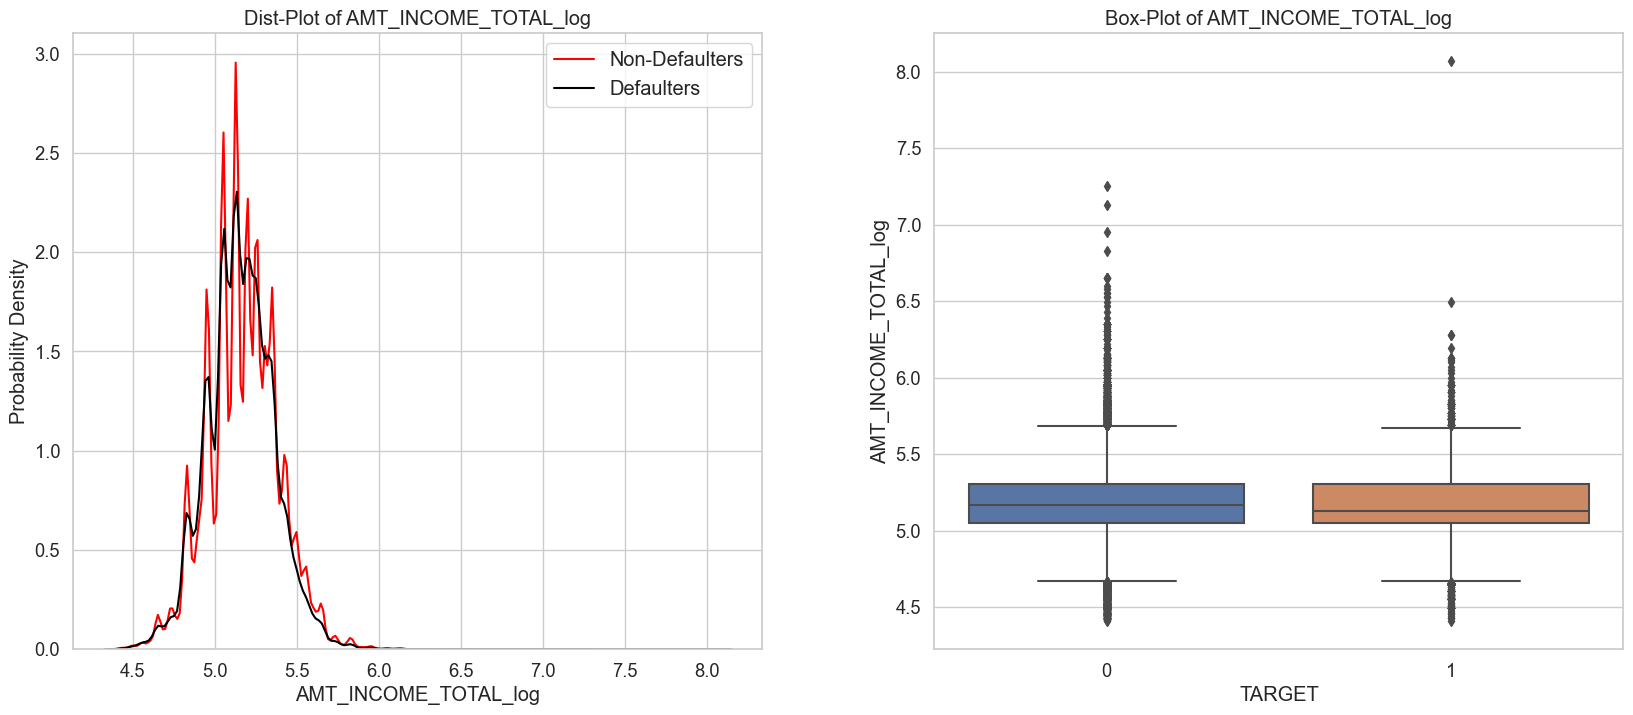

In [46]:
import numpy as np
application_train_copy = application_train.copy()
application_train_copy['AMT_INCOME_TOTAL_log'] = np.log10(application_train_copy['AMT_INCOME_TOTAL'])
plot_continuous_variables(application_train_copy, 'AMT_INCOME_TOTAL_log', plots = ['distplot','box' ] )

C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


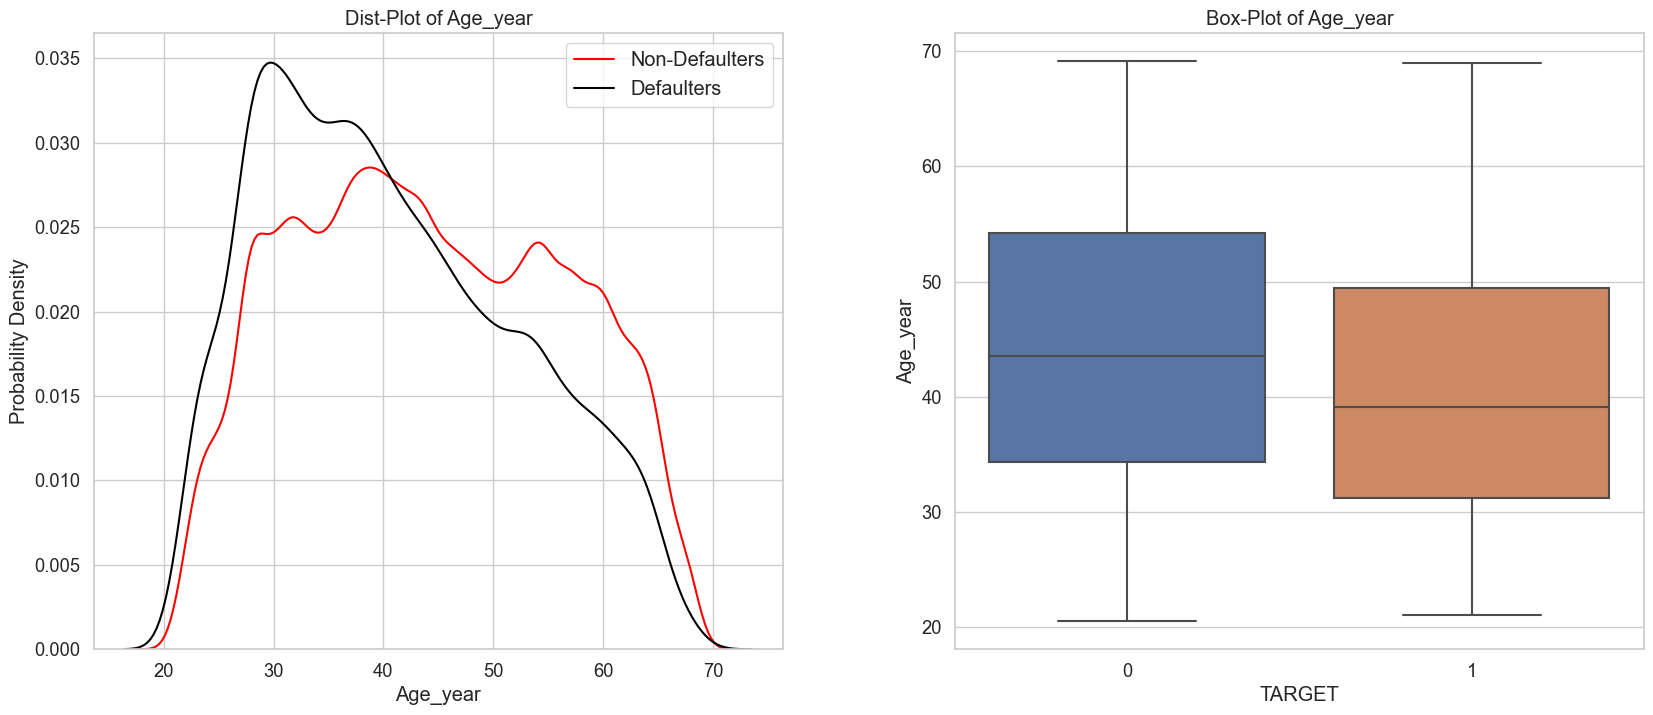

In [47]:
import numpy as np
application_train_copy['Age_year'] = application_train_copy['DAYS_BIRTH']/-365
plot_continuous_variables(application_train_copy, 'Age_year', plots = ['distplot','box' ])

C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


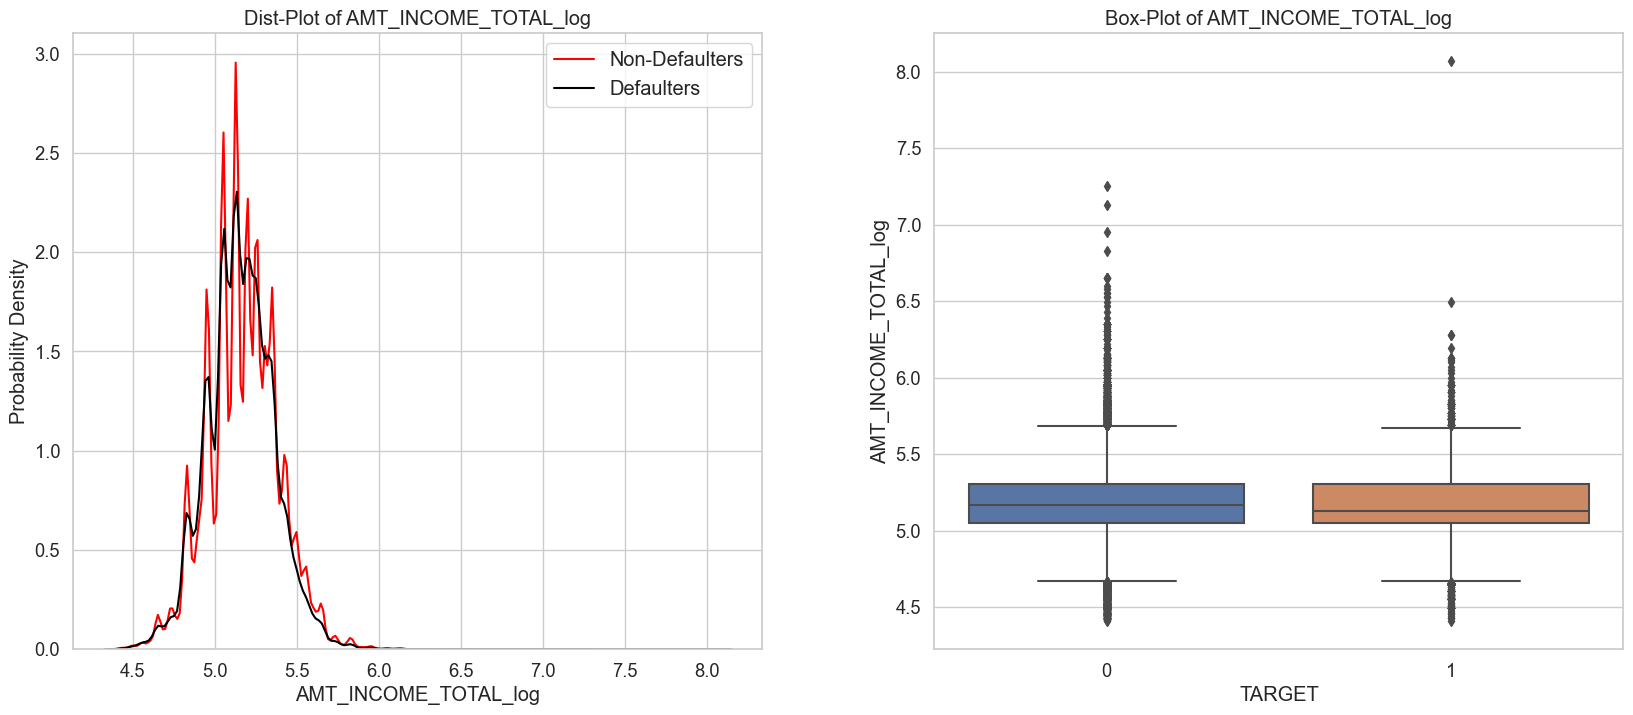

In [48]:
application_train_copy['AMT_INCOME_TOTAL_log'] = np.log10(application_train_copy['AMT_INCOME_TOTAL'])
plot_continuous_variables(application_train_copy, 'AMT_INCOME_TOTAL_log', plots = ['distplot','box' ])

### Features engineering

#### Supprimer les variables non pertinentes 

Il y a beaucoup de colonnes portant sur le logement du client, avec des définitions peu claires.  
Dans un premier temps nous allons étudier les corrélations en ces variables : 

In [49]:
application_train.iloc[:, 48:86].columns

Index(['COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'],
      dtype='object')

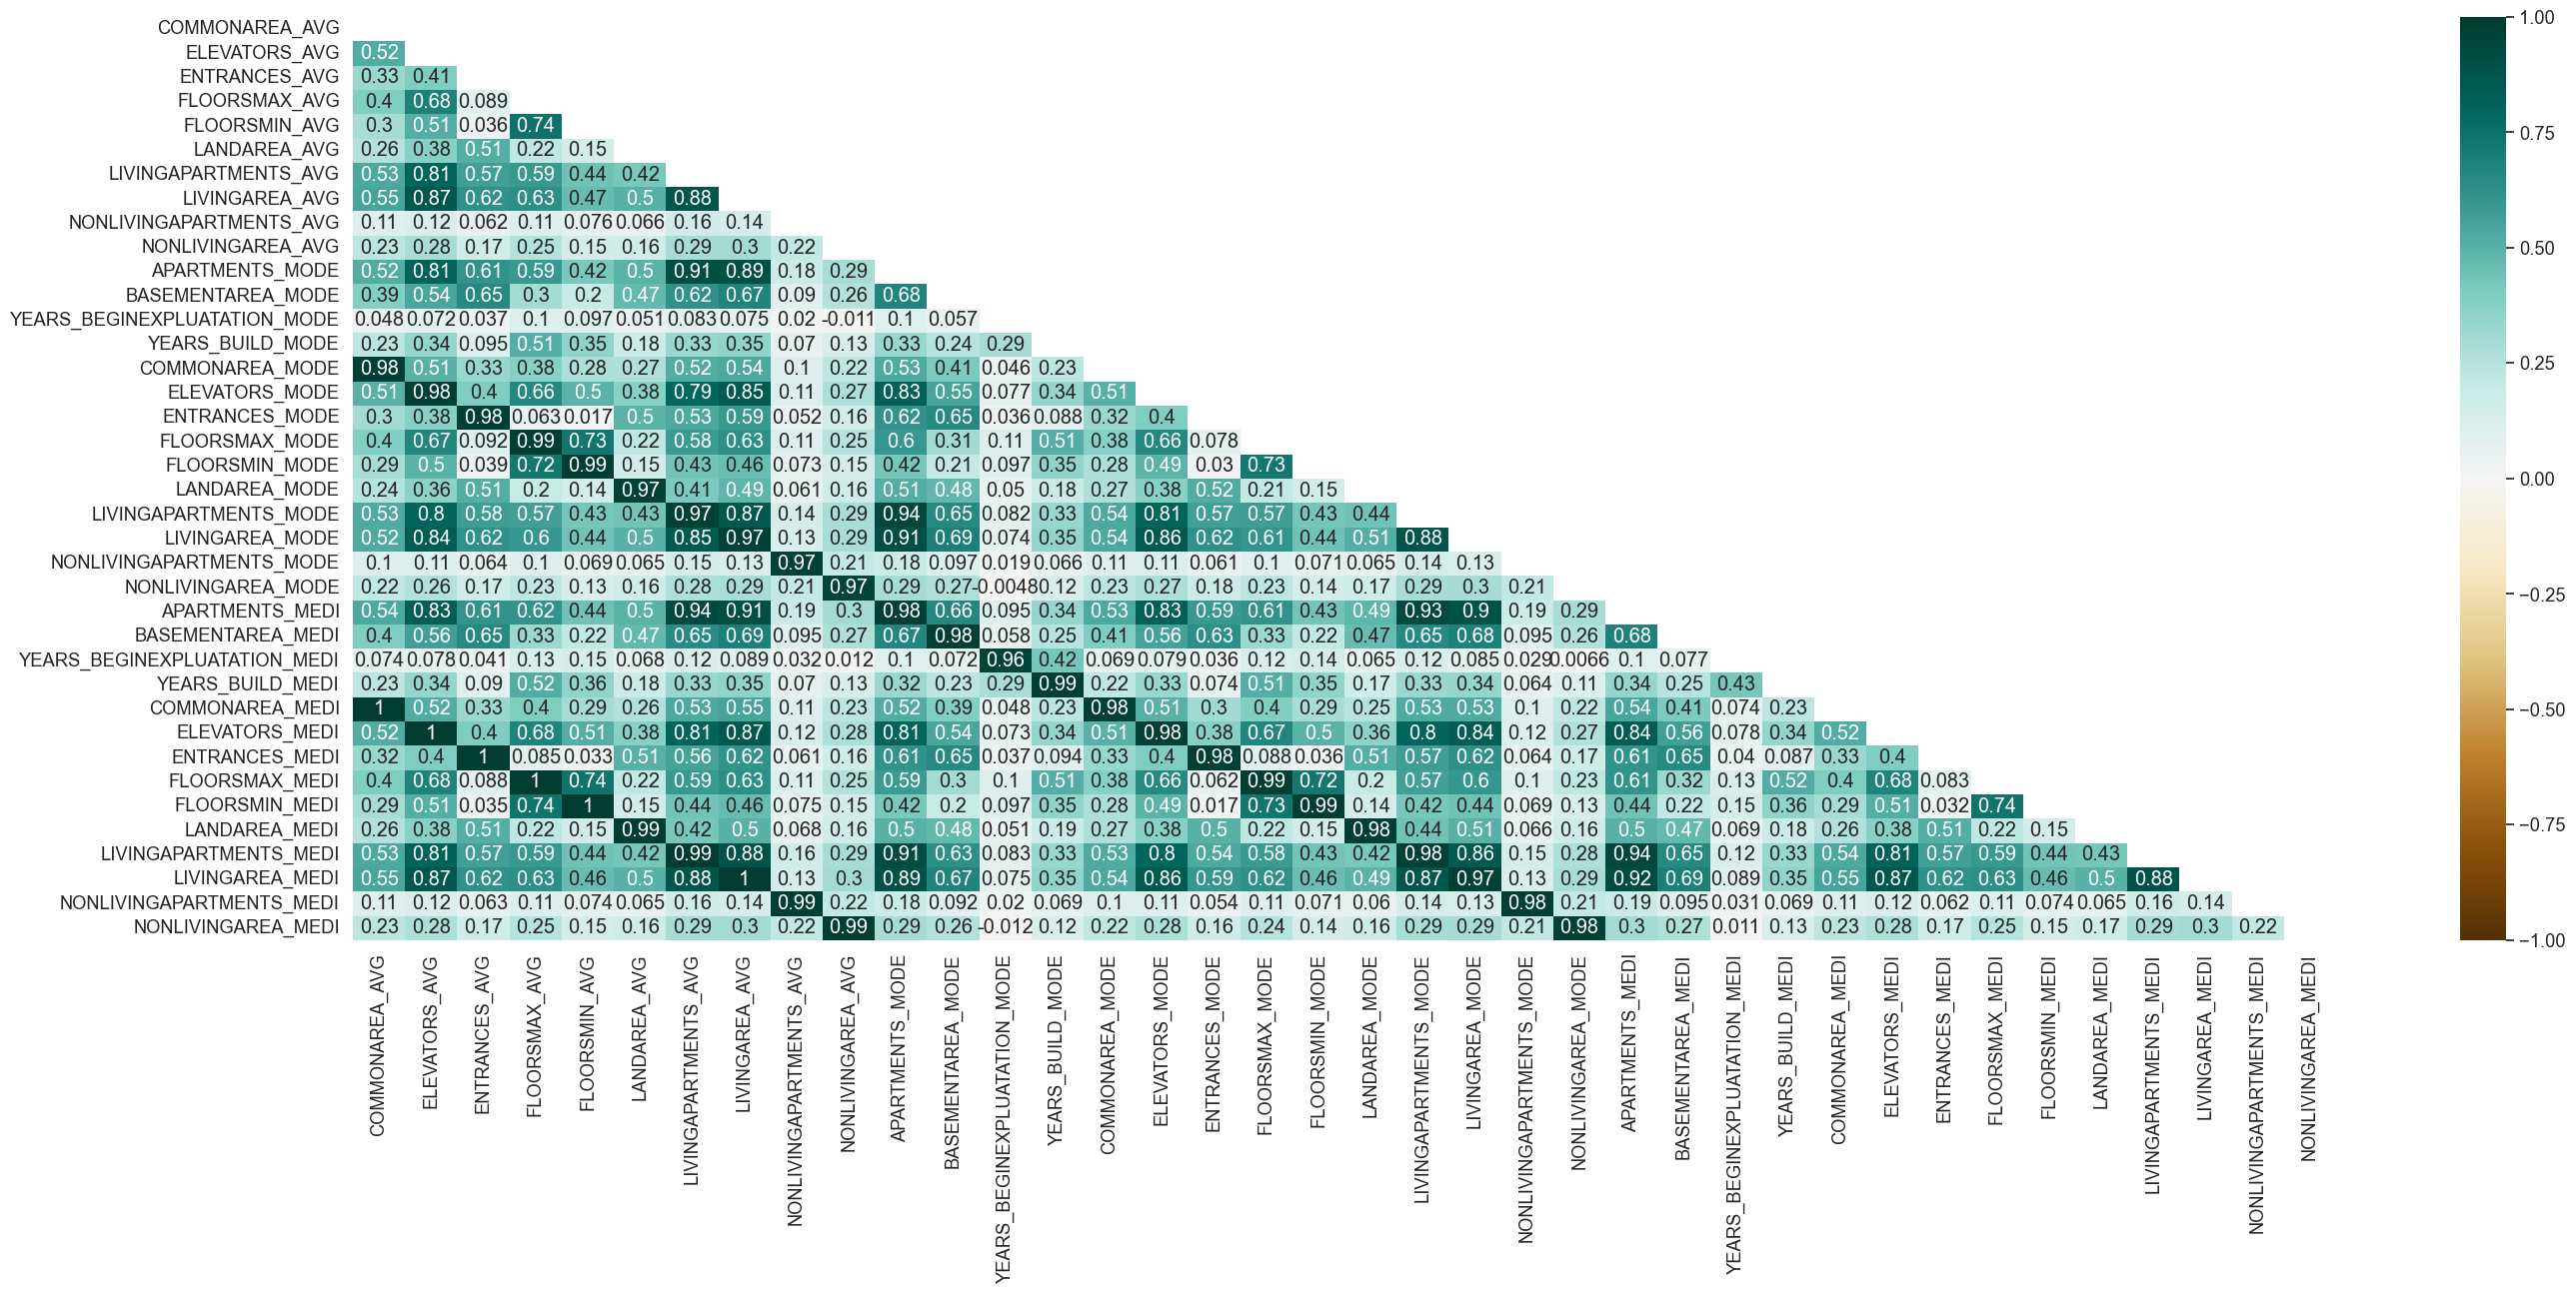

In [50]:
plt.figure(figsize=(32, 12))
mask = np.triu(np.ones_like(application_train.iloc[:, 48:86].corr(), dtype=np.bool))
heatmap = sns.heatmap(application_train.iloc[:, 48:86].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')


**Le constat est sans appel, les variables sont presques identiques à suffixes prés, nous conservons alors uniquement le suffixe _MEDI et supprimons les autres**

In [51]:
col_to_del = []
for col in application_train.iloc[:, 48:86].columns :
    if '_MEDI' not in col :
        col_to_del.append(col)

**Les variables** :  
- WEEKDAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START  
- DAYS_LAST_PHONE_CHANGE
- CODE_GENDER
Nous ne pouvons pas baser nos analyses sur ces variables pour expliquer pourquoi son prêt est refusé.


In [52]:
col_to_del.append('WEEKDAY_APPR_PROCESS_START')
col_to_del.append('HOUR_APPR_PROCESS_START')

In [53]:
application_train = application_train.drop(columns = col_to_del)
application_test = application_test.drop(columns = col_to_del)

#### Encodage des variables

Pour les variables catégorielles qui comportent plus de deux catégories nous allons effectuer un one hot encoding, c'est à dire que pour chaque valeurs prises par une variable nous allons lui associer une colonne avec des valeurs binaires (1 si oui 0 sinon)

In [54]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#### Identification des variables catégorielles

In [55]:
categorical_columns = [col for col in application_train.columns if application_train[col].dtype == 'object']

In [56]:
for col_cat in categorical_columns:
    is_nan = pd.isna(application_train[col_cat].unique()).sum()
    print(f" nombre de modalité de {col_cat} : {len(application_train[col_cat].unique()) - is_nan}")

 nombre de modalité de NAME_CONTRACT_TYPE : 2
 nombre de modalité de CODE_GENDER : 3
 nombre de modalité de FLAG_OWN_CAR : 2
 nombre de modalité de FLAG_OWN_REALTY : 2
 nombre de modalité de NAME_TYPE_SUITE : 7
 nombre de modalité de NAME_INCOME_TYPE : 8
 nombre de modalité de NAME_EDUCATION_TYPE : 5
 nombre de modalité de NAME_FAMILY_STATUS : 6
 nombre de modalité de NAME_HOUSING_TYPE : 6
 nombre de modalité de OCCUPATION_TYPE : 18
 nombre de modalité de ORGANIZATION_TYPE : 58
 nombre de modalité de FONDKAPREMONT_MODE : 4
 nombre de modalité de HOUSETYPE_MODE : 3
 nombre de modalité de WALLSMATERIAL_MODE : 7
 nombre de modalité de EMERGENCYSTATE_MODE : 2


Pour la varible ORGANIZATION_TYPE nous ne gardons que les valeurs avec plus de 100 observations.

In [57]:
ORGANIZATION_TYPE_col_other = []
for mod_ in application_train['ORGANIZATION_TYPE'].unique():
    mask = application_train['ORGANIZATION_TYPE'] == mod_
    if len(application_train[mask]) <100 :
        ORGANIZATION_TYPE_col_other.append(mod_)

In [58]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [59]:
ORGANIZATION_TYPE_col_other

['Religion',
 'Trade: type 5',
 'Industry: type 13',
 'Trade: type 4',
 'Industry: type 8']

In [60]:
application_train[['ORGANIZATION_TYPE']].value_counts() 

ORGANIZATION_TYPE     
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7 

Nous ne devons donc pas encoder en one hot les variables 'FLAG_OWN_CAR' et 'FLAG_OWN_REALTY'  

#### Anomalie

La variable 'CODE_GENDER' contient des valeurs XNA, nous supprimererons les lignes associés (4)

In [61]:
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Il y a une anomalie sur la variables DAYS_EMPLOYED : (Combien de jours avant la demande la
personne a commencé son emploi actuel,temps relatif à la demande uniquement).  
Il y a une valeurs incohérente = 365243

365243


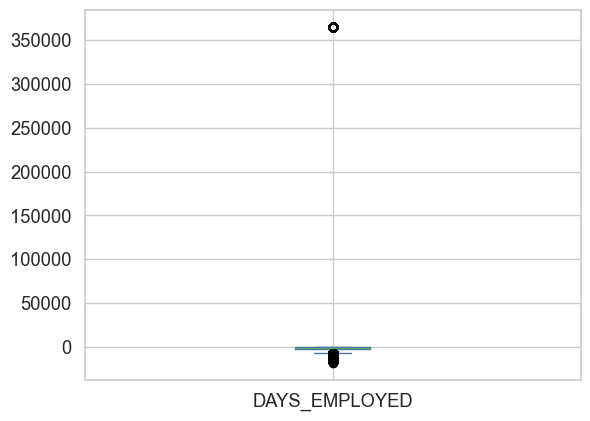

In [62]:
application_train['DAYS_EMPLOYED'].plot.box()
print(application_train['DAYS_EMPLOYED'].max())

Nous allons la retirer

#### Création de nouvelles variables

Nous allons creer les variables suivantes :   
- DAYS_EMPLOYED_PERC : Nombre de jours moyens travaillé (Nombre de jours ou les client à travailler divisé par son age )
- DAYS_EMPLOYED_PERC : ratio entre Revenu du client / Montant du crédit de l'emprunt
- INCOME_PER_PERSON : Revenu du client / du membres de la famille du client
- ANNUITY_INCOME_PERC : Annuité du crédit / Revenu du client par an
- PAYMENT_RATE : poucentage du crédit à rembourser par an

**Fonction finale**

Cette fonction recapitule les points énoncés plus haut.  
4 features sont supprimées.

In [63]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(col_to_del = None, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    
    col_to_del = []
    for col in df.iloc[:, 48:86].columns :
        if '_MEDI' not in col :
            col_to_del.append(col)
    col_to_del.append('WEEKDAY_APPR_PROCESS_START')
    col_to_del.append('HOUR_APPR_PROCESS_START')
    col_to_del.append('DAYS_LAST_PHONE_CHANGE')
    col_to_del.append('CODE_GENDER')
    
    #changer les professions peu présentes en other
    ORGANIZATION_TYPE_col_other = []
    for mod_ in df['ORGANIZATION_TYPE'].unique():
        mask = df['ORGANIZATION_TYPE'] == mod_
        if len(df[mask]) <100 :
            ORGANIZATION_TYPE_col_other.append(mod_)
    
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    df = df.append(test_df).reset_index()
    df.drop(columns = col_to_del, inplace = True)
    df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(ORGANIZATION_TYPE_col_other,'Other')
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)  
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


## Bureau et Bureau_balance

### Description des jeux de données

**Description bureau :** 

- Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au Bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
- Pour chaque prêt de notre jeu de données, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

**Description bureau_balance :**  
- Soldes mensuels des crédits précédents dans le Credit Bureau
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit antérieur rapporté au Credit Bureau - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de crédits antérieurs relatifs * # de mois où nous avons un historique observable pour les crédits antérieurs) des lignes.

In [64]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [65]:
bureau_balance.head(10)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C
5       5715448              -5      C
6       5715448              -6      C
7       5715448              -7      C
8       5715448              -8      C
9       5715448              -9      0

In [66]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [67]:
print(f'Le jeu de données bureau contient {bureau.shape[0]} lignes et {bureau.shape[1]} colonnes') 
print(f'Le jeu de données bureau_balance contient {bureau_balance.shape[0]} lignes et {bureau_balance.shape[1]} colonnes') 

Le jeu de données bureau contient 1716428 lignes et 17 colonnes
Le jeu de données bureau_balance contient 27299925 lignes et 3 colonnes


### Valeurs manquantes

**bureau**

Le total des Valeurs manquantes est 3939947soit 13.502552290879322 %


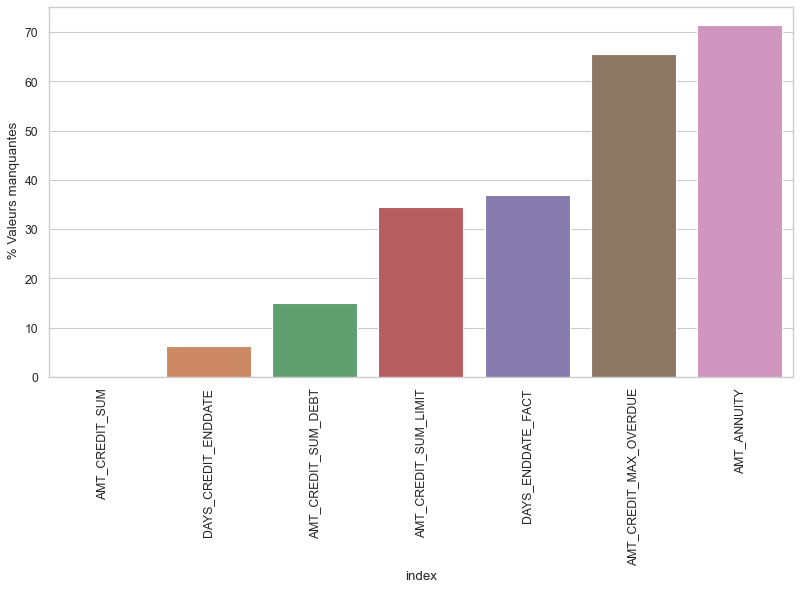

In [68]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

tot_val = bureau.shape[0]*bureau.shape[1]
print(f'Le total des Valeurs manquantes est {bureau.isna().sum().sum()}\
soit {bureau.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(bureau.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = bureau.isna().sum()/bureau.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 90)
plt.show()

**bureau_balance**

In [69]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

tot_val = bureau_balance.shape[0]*bureau_balance.shape[1]
print(f'Le total des Valeurs manquantes est {bureau_balance.isna().sum().sum()}\
soit {bureau_balance.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(bureau_balance.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = bureau_balance.isna().sum()/bureau_balance.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')
missVal

Le total des Valeurs manquantes est 0soit 0.0 %


index  Valeurs manquantes   % Valeurs manquantes
0    SK_ID_BUREAU                   0                    0.0
1  MONTHS_BALANCE                   0                    0.0
2          STATUS                   0                    0.0

### Unification des jeux de données avec feature engineering

Nous devons relier les deux dataframes entre eux, ici à l'aide de la colonne SK_ID_BUREAU  
Dans bureau_balance nous avons le mois du solde par rapport à la date de la demande ainsi que le statut du prêt au cours de ce mois.    
Pour associer toutes ces valeurs historiques à un unique SK_ID_CURR nous allons effectuer la moyenne des mois pour chacun des satus possibles, ainsi que le month balance minimum, maximum et la longueur du prêt

**Encoding des variables catégorielles**

In [70]:
num_rows = None
nan_as_category = True
bureau = pd.read_csv('bureau.csv', nrows = num_rows)
bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
bb, bb_cat = one_hot_encoder(bb, nan_as_category)
bureau, bureau_cat = one_hot_encoder(bureau, True)

In [71]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']


In [72]:
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'STATUS_nan': ['mean']}

**Créations des nouvelles features pour bureau_balance comme énoncé plus haut**

In [ ]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg

In [ ]:
len(bb_agg.index.unique())

**Unification des deus dataframes selon SK_ID_BUREAU**

In [ ]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

In [43]:
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
bureau

SK_ID_CURR  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0            215354         -497                   0               -153.0   
1            215354         -208                   0               1075.0   
2            215354         -203                   0                528.0   
3            215354         -203                   0                  NaN   
4            215354         -629                   0               1197.0   
...             ...          ...                 ...                  ...   
1716423      259355          -44                   0                -30.0   
1716424      100044        -2648                   0              -2433.0   
1716425      100044        -1809                   0              -1628.0   
1716426      246829        -1878                   0              -1513.0   
1716427      246829         -463                   0                  NaN   

         DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0                   -153.0                     NaN                   0   
1                      NaN                     NaN                   0   
2                      NaN                     NaN                   0   
3                      NaN                     NaN                   0   
4                      NaN                 77674.5                   0   
...                    ...                     ...                 ...   
1716423                NaN                     0.0                   0   
1716424            -2493.0                  5476.5                   0   
1716425             -970.0                     NaN                   0   
1716426            -1513.0                     NaN                   0   
1716427             -387.0                     NaN                   0   

         AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  ...  \
0              91323.00                  0.0                   NaN  ...   
1             225000.00             171342.0                   NaN  ...   
2             464323.50                  NaN                   NaN  ...   
3              90000.00                  NaN                   NaN  ...   
4            2700000.00                  NaN                   NaN  ...   
...                 ...                  ...                   ...  ...   
1716423        11250.00              11250.0                   0.0  ...   
1716424        38130.84                  0.0                   0.0  ...   
1716425        15570.00                  NaN                   NaN  ...   
1716426        36000.00                  0.0                   0.0  ...   
1716427        22500.00                  0.0                   NaN  ...   

         MONTHS_BALANCE_SIZE  STATUS_0_MEAN  STATUS_1_MEAN  STATUS_2_MEAN  \
0                        NaN            NaN            NaN            NaN   
1                        NaN            NaN            NaN            NaN   
2                        NaN            NaN            NaN            NaN   
3                        NaN            NaN            NaN            NaN   
4                        NaN            NaN            NaN            NaN   
...                      ...            ...            ...            ...   
1716423                  NaN            NaN            NaN            NaN   
1716424                  NaN            NaN            NaN            NaN   
1716425                  NaN            NaN            NaN            NaN   
1716426                  NaN            NaN            NaN            NaN   
1716427                  NaN            NaN            NaN            NaN   

         STATUS_3_MEAN  STATUS_4_MEAN  STATUS_5_MEAN  STATUS_C_MEAN  \
0                  NaN            NaN            NaN            NaN   
1                  NaN            NaN            NaN            NaN   
2                  NaN            NaN            NaN            NaN   
3                  NaN            NaN            NaN            NaN   
4             

Nous constatons ici que certain clients ont contractés plusieurs crédits et donc qu'il faut passer passer par une seconde étape pour obtenir une unique valeur par ID

In [48]:
len(bureau['SK_ID_CURR'].unique()) # bien inférieur à 1716428 

305811

**Créations des nouvelles features pour le dataframe unifié**  
On procède manière similaire, on passe par la moyenne, le min, max, var, la somme. En fonction des variables nous décidons d'avoir seulement la moyenne ou alors d'informations.  
Comme ci dessous : 

In [11]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

NameError: name 'bureau_cat' is not defined

Comme précédement on utilise la méthode groupby ainsi que la fonction agg pour calculer toutes ces statistiques selon les variables.  
Nous différençons les cas ou le prêt en question est en cours ou alors déjà terminé.

In [50]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau
gc.collect()
bureau_agg

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   
...                          ...                   ...                    ...   
456249                     -2713                  -483           -1667.076923   
456250                     -1002                  -760            -862.000000   
456253                      -919                  -713            -867.500000   
456254                     -1104                 -1104           -1104.000000   
456255                     -2337                  -363           -1089.454545   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   
...                          ...                           ...   
456249             407302.243590                       -2499.0   
456250              15724.000000                        -272.0   
456253              10609.000000                        -189.0   
456254                       NaN                        -859.0   
456255             502786.672727                       -1243.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   
...                                  ...                            ...   
456249                            1363.0                   -1232.333333   
456250                            2340.0                    1288.333333   
456253                            1113.0                     280.500000   
456254                            -859.0                    -859.000000   
456255                           27320.0                    3231.272727   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   
...                                  ...                          ...   
456249                      -1064.538462                            0   
456250                        -60.333333                            0   
456253                       -253.250000                            0   
456254                       -401.000000                            0   
456255                       -531.090909                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  ...  \
SK_ID_CURR                                ...   
100001                               0.0  ...   
100002                    

**Fonction globale qui récapitule pas à pas les étapes précédentes**

In [4]:
import gc

def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

## Previous_applications

### Description du jeu de données

- Toutes les demandes précédentes de prêts pour le crédit des clients qui ont des prêts dans notre échantillon.

In [59]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [60]:
print(f'Le jeu de données bureau contient {previous_application.shape[0]} lignes et {previous_application.shape[1]} colonnes') 

Le jeu de données bureau contient 1670214 lignes et 37 colonnes


### Valeurs manquantes

Le total des Valeurs manquantes est 11109336soit 17.97687747344498 %


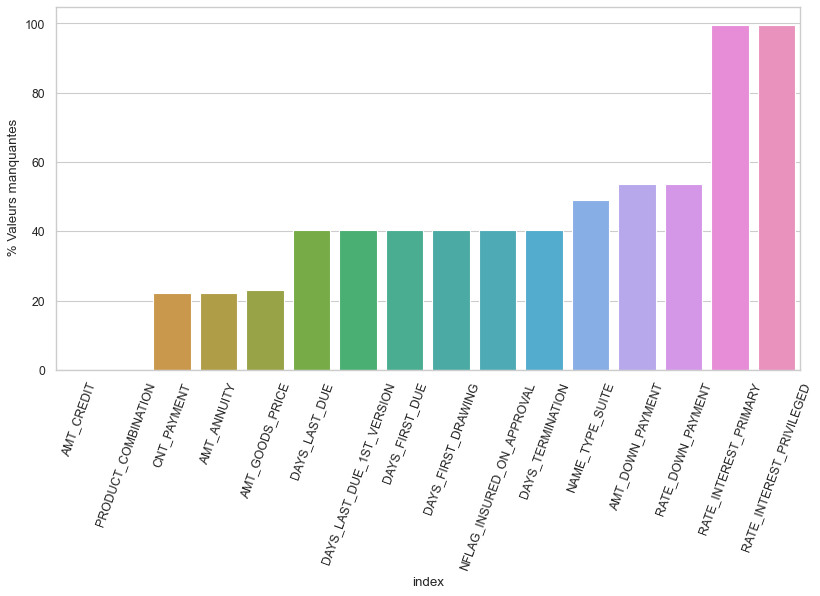

In [62]:
tot_val = previous_application.shape[0]*previous_application.shape[1]
print(f'Le total des Valeurs manquantes est {previous_application.isna().sum().sum()}\
soit {previous_application.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(previous_application.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = previous_application.isna().sum()/previous_application.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 70)
plt.show()

### Anomalies

Avant de passer à la partie feature engineering nous devons verifier qu'il n'y a pas de valeurs abérentes dans les données.

In [64]:
previous_application.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  \
count            5951.000000               5951.000000   1.670214e+06   
mean                0.188357                  0.773503  -8.806797e+02   
std                 0.087671                  0.100879   7.790997e+02   
min                 0.034781                  0.373150  -2.922000e+03   
25%                 0.160716                  0.715645  -1.300000e+03   
50%                 0.189122                  0.835095  -5.810000e+02   
75%                 0.193330                  0.852537  -2.800000e+02   
max                 1.000000                  1.000000  -1.000000e+00   

       SELLERPLACE_AREA   CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count      1.670214e+06  1.297984e+06       997149.000000   997149.000000   
mean       3.139511e+02  1.605408e+01       342209.855039    13826.269337   
std        7.127443e+03  1.456729e+01        88916.115834    72444.869708   
min       -1.000000e+00  0.000000e+00        -2922.000000    -2892.000000   
25%       -1.000000e+00  6.000000e+00       365243.000000    -1628.000000   
50%        3.000000e+00  1.200000e+01       365243.000000     -831.000000   
75%        8.200000e+01  2.400000e+01       365243.000000     -411.000000   
max        4.000000e+06  8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.0000

Nous constatons des valeurs maxiales abérentes pour les colonnes DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION.  
En effet ces variables doivent prendre des valeurs en jours relatives à la date du prêt or nous avons toujours la même valeur : 365243 (bien trop grand).  
Ces valeurs sont remplacées par des nan.

In [71]:
import numpy as np
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
prev.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  \
count            5951.000000               5951.000000   1.670214e+06   
mean                0.188357                  0.773503  -8.806797e+02   
std                 0.087671                  0.100879   7.790997e+02   
min                 0.034781                  0.373150  -2.922000e+03   
25%                 0.160716                  0.715645  -1.300000e+03   
50%                 0.189122                  0.835095  -5.810000e+02   
75%                 0.193330                  0.852537  -2.800000e+02   
max                 1.000000                  1.000000  -1.000000e+00   

       SELLERPLACE_AREA   CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count      1.670214e+06  1.297984e+06        62705.000000   956504.000000   
mean       3.139511e+02  1.605408e+01        -1035.246791    -1106.583027   
std        7.127443e+03  1.456729e+01          922.710316      790.703113   
min       -1.000000e+00  0.000000e+00        -2922.000000    -2892.000000   
25%       -1.000000e+00  6.000000e+00        -1721.000000    -1676.000000   
50%        3.000000e+00  1.200000e+01         -621.000000     -874.000000   
75%        8.200000e+01  2.400000e+01         -303.000000     -459.000000   
max        4.000000e+06  8.400000e+01           -2.000000       -2.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              903285.000000  785928.000000     771236.000000   
mean                 -677.158175    -996.179128       -978.375222   
std                   923.601152     752.703178        749.134297   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1359.000000   -1566.000000      -1539.000000   
50%                  -480.000000    -801.000000       -780.000000   
75%                    -2.000000    -353.000000       -337.000000   
max                  2389.000000      -2.000000         -2.000000   

       NFLAG_INSURED_ON_APPROVAL  NAME_CONTRACT_TYPE_Cash loans  \
count              997149.000000                   1.670214e+06   
mean                    0.332570                   4.475792e-01   
std 

Le problème est résolu

### Feature engineering et encodage

Pour les variables catégorielles nous procédons à un encodage one hot 

In [70]:
prev = previous_application.copy()
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

**Méthodologie**

Comme précédemment nous avons une ligne par crédit identifiée par SK_ID_PREV. L'objectif reste le même, c'est à dire de calculer des indicateurs statistiques (min, max, moy..) propres à chaque client/demande dans le jeu train/test.  
Ces nouvelles variables sont distinguées selon les deux cas ou le contrat est approuvé (NAME_CONTRACT_STATUS_Approved = 1) ou alors refusé (NAME_CONTRACT_STATUS_Refused = 1)

**Nouvelle feature**   
Nous créons une nouvelle variable APP_CREDIT_PERC = rappot entre le montant demandé et le montant accordé lors de la précédente demande.  
AMT_APPLICATION = Pour quel montant de crédit le client a-t-il demandé lors de la demande précédente  
AMT_CREDIT = Montant finalement accordé au crédit demandé lors de la demande précédente

In [73]:
# Indicateurs spécifiques pour les variables suivantes :
num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
# Création de la nouvelle feature
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
# Sinon on garde seulement la moyenne
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

# Calcul de ces indicateurs statistiques par variable
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Distinction entre NAME_CONTRACT_STATUS_Approved et NAME_CONTRACT_STATUS_Refused
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [74]:
prev_agg.head()

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   
100003                  6737.310             98356.995              56553.990   
100004                  5357.250              5357.250               5357.250   
100005                  4813.200              4813.200               4813.200   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                       24835.50              23787.0   
100002                      179055.00             179055.0   
100003                      435436.50              68053.5   
100004                       24282.00              20106.0   
100005                       22308.75                  0.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_APP_CREDIT_PERC_MIN  PREV_APP_CREDIT_PERC_MAX  \
SK_ID_CURR                                                       
100001                      1.044079                  1.044079   
100002                      1.000000                  1.000000   
100003                      0.868825                  1.011109   
100004                      1.207699                  1.207699   
100005                      1.111173                  1.111173   

            PREV_APP_CREDIT_PERC_MEAN  PREV_APP_CREDIT_PERC_VAR  \
SK_ID_CURR                                                        
100001                       1.044079                       NaN   
100002                       1.000000                       NaN   
100003                       0.949329                  0.005324   
100004                       1.207699                       NaN   
100005                       1.111173                       NaN   

            PREV_AMT_DOWN_PAYMENT_MIN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                         
100001                         2520.0                     2520.0   
100002                            0.0                        0.0   
100003                            0.0                     6885.0   
100004                         4860.0                     4860.0   
100005                         4464.0                     4464.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MIN  \
SK_ID_CURR                                                         
100001                          2520.0                   24835.5   
100002                             0.0                  179055.0   
100003                          3442.5                   68809.5   
100004                          4860.0                   24282.0   
100005                          4464.0                   44617.5   

            PREV_AMT_GOODS_PRICE_MAX  PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                                                        
100001                       24835.5                    24835.5   
100002                      179055.0                   179

**Fonction finale**  
Recapitule les étapes précédentes

In [5]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


## POS_CASH_balance

### Description du jeu de données

- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.  
- Nous avons accès par exemple au nombre de jours de retard sur le prêt durant le mois précédent, nombre de Versements restant à payer

In [14]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [15]:
print(f'Le jeu de données bureau contient {POS_CASH_balance.shape[0]} lignes et {POS_CASH_balance.shape[1]} colonnes') 

Le jeu de données bureau contient 10001358 lignes et 8 colonnes


### Valeurs manquantes 

Le total des Valeurs manquantes est 52158soit 0.06518864738168557 %


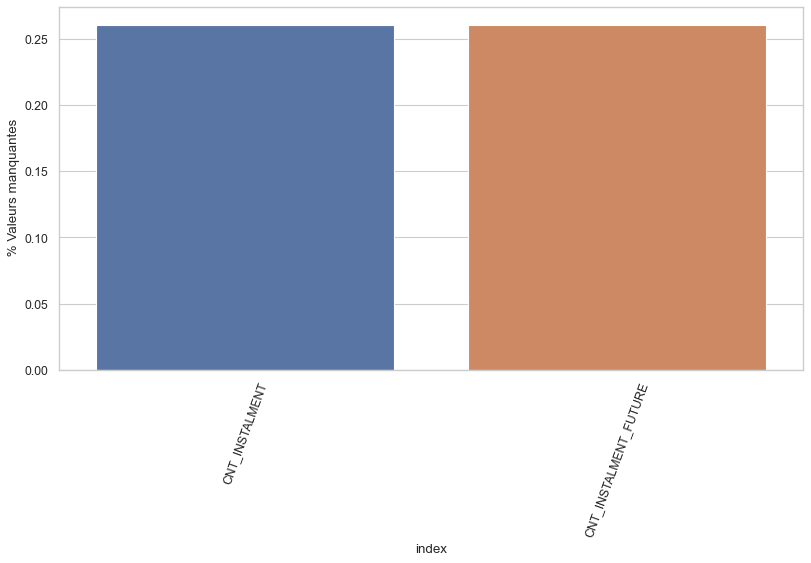

In [78]:
tot_val = POS_CASH_balance.shape[0]*POS_CASH_balance.shape[1]
print(f'Le total des Valeurs manquantes est {POS_CASH_balance.isna().sum().sum()}\
soit {POS_CASH_balance.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(POS_CASH_balance.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = POS_CASH_balance.isna().sum()/POS_CASH_balance.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 70)
plt.show()

### Feature engineering et encodage

L'encodage one hot est selctionné pour les variables catégorielles

In [79]:
pos = POS_CASH_balance.copy()
pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

Comme pour le fichier previous_application nous devons extraires des indicateurs statistiques car nous avons plusieurs lignes par crédit.      
Nous ajoutons une nouvelle feature POS_COUNT qui représente le nombre de crédits présent dans la base pour un SK_ID_CURR donné.


In [80]:
 # Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

In [82]:
pos_agg.head()

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   
100003                                     0.071429   
100004                                     0.250000   
100005                                     0.090909   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     
100003                                                    0.0     
100004                                           

**Fonction totale**

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    

## Installments_payments

### Description du jeu de données

- Nous avons ici le détail des mensualités sur les prêts précédents, ce que le client devait payer et ce qu'il à finalement payé   
- La date relative en jour

In [85]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [94]:
print(f'Le jeu de données bureau contient {installments_payments.shape[0]} lignes et {installments_payments.shape[1]} colonnes') 

AttributeError: 'function' object has no attribute 'shape'

### Valeurs manquantes 

Le total des Valeurs manquantes est 5810soit 0.047920307530810745 %


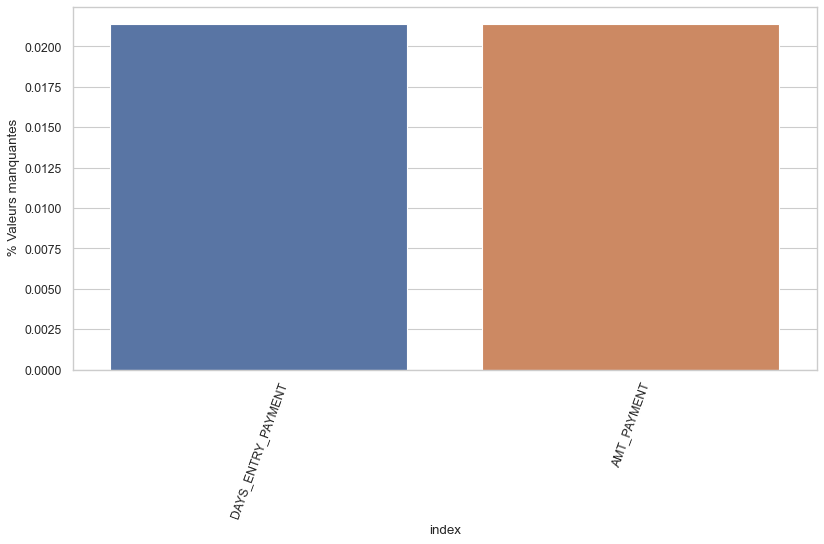

In [84]:
tot_val = installments_payments.shape[0]*installments_payments.shape[1]
print(f'Le total des Valeurs manquantes est {installments_payments.isna().sum().sum()}\
soit {installments_payments.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(installments_payments.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = installments_payments.isna().sum()/installments_payments.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 70)
plt.show()

### Feature engineering et encodage

Pour l'encodage des variables catégorielles nous utilisons le one hot encoding

**encodage**

In [86]:
ins = installments_payments.copy()
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

**Création de nouvelles features**  
Nous allons créer les features suivantes pour notre dataframe

PAYMENT_PERC : le ratio de la somme versée comparée à la mensualité du crédit ( ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'])  
PAYMENT_DIFF : non plus le ratio mais la différence brute (ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT'])  

- AMT_PAYMENT : Ce que le client a effectivement payé sur le crédit précédent pour ce versement
- AMT_INSTALMENT : Le montant du versement prescrit du crédit

DPD : la différence entre le moment virement et le moment attendu de ce virement ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']  
DBD : l'opposé de cette différence  ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']

- DAYS_ENTRY_PAYMENT : Quand l'échéance du crédit précédent a été effectivement payée 
- DAYS_INSTALMENT : Date à laquelle le paiment était attendu

On ne garde que les valeurs positives sur DPD et DBD sinon 0

In [87]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

Ensuite nous devons extraire les indicateurs statistiques des variables présentes (comme tout à l'heure il y à plusieurs lignes pour un même ID ).                                                                               

In [88]:
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [90]:
ins_agg.head()

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   
100003               179.0                      1.0                       1.0   
100004                23.0                      1.0                       1.0   
100005               213.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  INSTAL_PAYMENT_PERC_VAR  \
SK_ID_CURR                                                     
100001                          7.0                      0.0   
100002                         19.0                      0.0   
100003                         25.0                      0.0   
100004                          3.0                      0.0   
100005                          9.0                      0.0   

            INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                      
100001                          0.0                       0.0   
100002                          0.0                       0.0   
100003                          0.0                       0.0   
100004                          0.0                       0.0   
100005                          0.0                       0.0   

            INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
SK_ID_CURR                                                     
100001                          0.0                      0.0   
100002                          0.0                      0.0   
100003                          0.0                      0.0   
100004                          0.0                      0.0   
100005                          0.0                      0.0   

            INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                                                          
100001                      17397.900                 5885.132143   
100002                      53093.745                11559.247105   
100003                     560835.360                64754.586000   
100004                      10573.965                 7096.155000   
100005                      17656.245                 6240.205000   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   
100003                    1618864.650                6662.970   
100004                      21288.465                5357.250   
100005                      56161.845                4813.200   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                

**Fonction globale**

In [7]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

## Credit_card_balance

### Description du jeu de données 

Ce sont des informations sur l'utilisation et le solde de la carte associée au crédit précédent.

- Soldes mensuels des cartes de crédit précédentes que le demandeur possède auprès de Home Credit.  
- Montant des prélèvements du crédit pour un mois donné, montant des autres prélèvements/achats (nombre de retraits sur les distributeurs automatiques...) etc

In [93]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [95]:
print(f'Le jeu de données bureau contient {credit_card_balance.shape[0]} lignes et {credit_card_balance.shape[1]} colonnes') 

Le jeu de données bureau contient 3840312 lignes et 23 colonnes


### Valeurs manquantes

Le total des Valeurs manquantes est 5877356soit 6.654074392687479 %


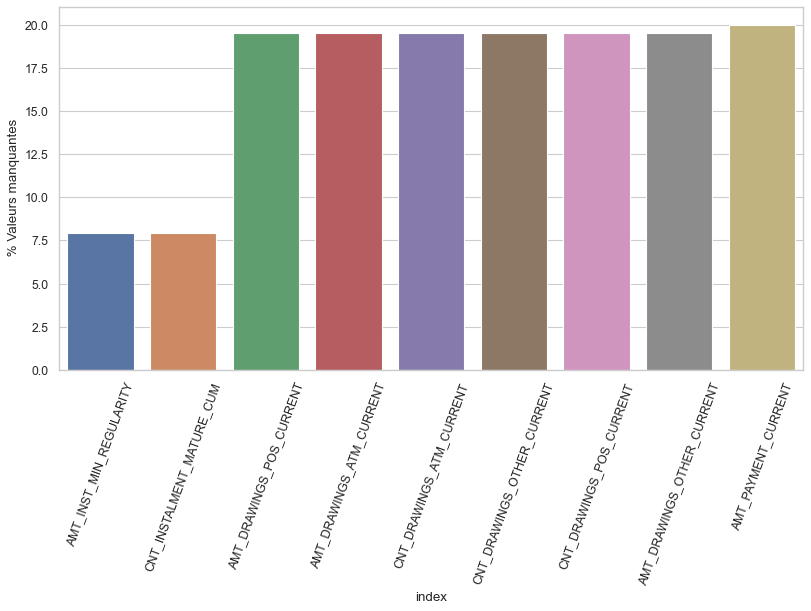

In [96]:
tot_val = credit_card_balance.shape[0]*credit_card_balance.shape[1]
print(f'Le total des Valeurs manquantes est {credit_card_balance.isna().sum().sum()}\
soit {credit_card_balance.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(credit_card_balance.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = credit_card_balance.isna().sum()/credit_card_balance.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 70)
plt.show()

### Features engineering et encodage

**Encodage**

Pour l'encodage des variables catégorielles nous utilisons le one hot encoder

In [97]:
cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

**Extraction des indicateurs statistiques**  
Puisqu'il y a plusieurs lignes pour un ID nous allons calculer certain indicateurs statistiques en fonction des variables

In [99]:
 cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

**Nouvelles feature**  
Nous allons simplement compter le nombre de ligne présentes pour chaque ID dans une variable CC_COUNT

In [100]:
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [101]:
cc_agg.head()

CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                0.00   
100011                      462.5                 0.0           189000.00   
100013                      776.0                 0.0           161420.22   
100021                       25.5                 0.0                0.00   
100023                        6.0                 0.0                0.00   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  \
SK_ID_CURR                                                                
100006                 0.000000               0.000        0.000000e+00   
100011             54482.111149         4031676.225        4.641321e+09   
100013             18159.919219         1743352.245        1.869473e+09   
100021                 0.000000               0.000        0.000000e+00   
100023                 0.000000               0.000        0.000000e+00   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MIN  CC_AMT_CREDIT_LIMIT_ACTUAL_MAX  \
SK_ID_CURR                                                                   
100006                              270000                          270000   
100011                               90000                          180000   
100013                               45000                          157500   
100021                              675000                          675000   
100023                               45000                          225000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  \
SK_ID_CURR                                                                    
100006                        270000.000000                         1620000   
100011                        164189.189189                        12150000   
100013                        131718.750000                        12645000   
100021                        675000.000000                        11475000   
100023                        135000.000000                         1080000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_VAR  CC_AMT_DRAWINGS_ATM_CURRENT_MIN  \
SK_ID_CURR                                                                    
100006                        0.000000e+00                              NaN   
100011                        1.189060e+09                              0.0   
100013                        2.259252e+09                              0.0   
100021                        0.000000e+00                              NaN   
100023                        9.257143e+09                              NaN   

            CC_AMT_DRAWINGS_ATM_CURRENT_MAX  CC_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                      
100006                                  NaN                               NaN   
100011                             180000.0                       2432.432432   
100013                             157500.0                       6350.000000   
100021                               

**Fonction globale**

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

## sample_submission

rien de très pertient ici 

In [4]:
sample_submission['TARGET'].unique()

array([0.5])

In [5]:
sample_submission

SK_ID_CURR  TARGET
0          100001     0.5
1          100005     0.5
2          100013     0.5
3          100028     0.5
4          100038     0.5
...           ...     ...
48739      456221     0.5
48740      456222     0.5
48741      456223     0.5
48742      456224     0.5
48743      456250     0.5

[48744 rows x 2 columns]

## Unification des jeux de données

Nous avons à ce stade 6 jeux de données ayant en commun un unique SK_ID_CURR.  
Naturellement nous voulons les unifier au dataframe application_test/train pour avoir toutes les features facilement accessibles.   
Afin de ne pas avoir à run tout le code à la prochaine utilisation nous utilisons les fonctions globale présentes en fin de chaque analyse de fichier.

In [9]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

debug = False
num_rows = 10000 if debug else None

df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df_full = df.join(cc, how='left', on='SK_ID_CURR')
    del cc

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 41s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 80s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 29s
Installments payments df shape: (339587, 26)
Process installments payments - done in 70s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 61s


In [10]:
df_full.to_csv("data_chek_poin.csv")

In [125]:
import pandas as pd
import numpy as np
df_full = pd.read_csv("data_chek_poin.csv")

In [127]:
df_full.set_index('SK_ID_CURR', inplace = True)

In [128]:
print(f'Le jeu de données bureau contient {df_full.shape[0]} lignes et {df_full.shape[1]} colonnes') 

Le jeu de données bureau contient 356255 lignes et 760 colonnes


## Selection des variables

- Utiliser toutes les variables serait bien trop long en temps CPU. De plus certaines variables ne sont sans doute que peu utiles pour notre problème.  
- Une première méthode classique serait d'utiliser une ACP, mais cela viendrait ajouter trop de compléxité dans l'interprétabilité du modèle.


### Supprimer les colonnes avec trop de valeurs manquantes 

Nous voulons à terme avoir beaucoup moins de variables à traiter, ce qui nécéssite d'avoir des colonnes relativement pleines.    
Ici nous décidons de garder uniquement les colonnes avec moins de 30 % de valeurs manquantes.  

In [129]:
df_full.drop(columns = 'Unnamed: 0', inplace = True)
# On remplace au passage les valeurs inf par nan
#df_full.replace(np.inf, pd.Na)

In [131]:
tot_val = df_full.shape[0]*df_full.shape[1]
print(f'Le total des Valeurs manquantes est {df_full.isna().sum().sum()}\
soit {df_full.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(df_full.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = df_full.isna().sum()/df_full.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

Le total des Valeurs manquantes est 67088730soit 24.81114612190728 %


In [132]:
# On ne conserve que les colonnes avec mois de 30% de Nan
missVal_30 = missVal[missVal[' % Valeurs manquantes'] < 30]
col_selected = missVal_30['index'].values
df_full_30 = df_full[col_selected]
df_full_30.head()

index  OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
SK_ID_CURR                                                                    
100002          0                            0                            0   
100003          1                            0                            0   
100004          2                            0                            0   
100006          3                            0                            0   
100007          4                            0                            0   

            OCCUPATION_TYPE_Security staff  \
SK_ID_CURR                                   
100002                                   0   
100003                                   0   
100004                                   0   
100006                                   0   
100007                                   0   

            OCCUPATION_TYPE_Waiters/barmen staff  \
SK_ID_CURR                                         
100002                                         0   
100003                                         0   
100004                                         0   
100006                                         0   
100007                                         0   

            ORGANIZATION_TYPE_Advertising  ORGANIZATION_TYPE_Agriculture  \
SK_ID_CURR                                                                 
100002                                  0                              0   
100003                                  0                              0   
100004                                  0                              0   
100006                                  0                              0   
100007                                  0                              0   

            ORGANIZATION_TYPE_Bank  ORGANIZATION_TYPE_Business Entity Type 1  \
SK_ID_CURR                                                                     
100002                           0                                         0   
100003                           0                                         0   
100004                           0                                         0   
100006                           0                                         0   
100007                           0                                         0   

            ORGANIZATION_TYPE_Business Entity Type 2  ...  \
SK_ID_CURR                                            ...   
100002                                             0  ...   
100003                                             0  ...   
100004                                             0  ...   
100006                                             0  ...   
100007                                             0  ...   

            ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     NaN   
100006                                     NaN   
100007                                     NaN   

            ACTIVE_MONTHS_BALANCE_SIZE_SUM  ACTIVE_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                   
100002                                20.0                        245781.0   
100003                                 0.0                             0.0   
100004                                 NaN                             NaN   
100006                                 NaN                             NaN   
100007                                 NaN                             NaN   

            ACTIVE_AMT_CREDIT_SUM_SUM  ACTIVE_CREDIT_DAY_OVERDUE_MEAN  \
SK_ID_CURR                                                              
100002                     481988.565                             0.0   
100003                     810000.000                             0.0   
100004                            NaN                     

### Remplir les valeurs manquantes

La méthode selectKbest ne fonctionne pas avec des valeurs manquantes, nous devons donc les remplir de manière temporaire simplement pour les client avec la target déjà présente

In [133]:
import numpy as np

In [134]:
df_full_30_train = df_full_30[~df_full_30['TARGET'].isnull()].copy()
df_full_30_train = df_full_30_train.replace(np.inf , pd.NA)

tot_val = df_full_30_train.shape[0]*df_full_30_train.shape[1]
print(f'Le total des Valeurs manquantes est {df_full_30_train.isna().sum().sum()}\
soit {df_full_30_train.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(df_full_30.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = df_full_30_train.isna().sum()/df_full_30_train.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

Le total des Valeurs manquantes est 9978539soit 6.122523121277515 %


In [135]:
missVal[missVal['Valeurs manquantes']>0]

index  Valeurs manquantes   % Valeurs manquantes
166          DAYS_LAST_PHONE_CHANGE                   1               0.000325
167                 CNT_FAM_MEMBERS                   2               0.000650
168               INCOME_PER_PERSON                   2               0.000650
171             ANNUITY_INCOME_PERC                  36               0.003902
170                    PAYMENT_RATE                  36               0.003902
..                              ...                 ...                    ...
518   ACTIVE_CNT_CREDIT_PROLONG_SUM              104440              29.384640
517          ACTIVE_DAYS_CREDIT_MAX              104440              29.384640
521  ACTIVE_MONTHS_BALANCE_SIZE_SUM              104440              29.384640
528      ACTIVE_AMT_CREDIT_SUM_MEAN              104443              29.384965
529       ACTIVE_AMT_CREDIT_SUM_MAX              104443              29.384965

[364 rows x 3 columns]

**Nous remplaçons les valeurs manquantes des features suivantes par 0**  
- Les colonnes avec suffixe MEAN / MIN / SUM / MAX / VAR vont être placées à 0 car le manque d'information provient de l'absence de précédent crédits
- Pour les autres variables on suppose également que le manque d'information provient justement du fait qu'il n'y a pas d'information

In [136]:
col_fill_0 = []

matches = ['MEAN', 'VAR', 'MAX', 'MIN', 'SUM']
for idx in missVal.index:
  a_string = missVal.loc[idx, 'index']
  if any(x in a_string for x in matches):
    missVal.loc[idx, 'Valeurs manquantes'] = 0
    col_fill_0.append(a_string)
  
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_HOUR') 
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_MON')
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_QRT')
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_DAY')
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_WEEK')
col_fill_0.append('AMT_REQ_CREDIT_BUREAU_YEAR')
col_fill_0.append('INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE')
col_fill_0.append('INSTAL_COUNT')
col_fill_0.append('DAYS_EMPLOYED_PERC')
col_fill_0.append('DAYS_EMPLOYED')
col_fill_0.append('POS_COUNT')

In [137]:
df_full_30_train[col_fill_0] = df_full_30_train[col_fill_0].fillna(0)

**Les autres Features seront remplacées par la médiane**

In [138]:
df_full_30_train.fillna(value = df_full_30_train.median(), inplace = True)

### Utilisation de selectKbest

In [139]:
from sklearn.feature_selection import SelectKBest
 
X_kbest = df_full_30_train.drop("TARGET" ,axis= 1)
y_kbest = df_full_30_train['TARGET']

In [140]:
Kbest_obj = SelectKBest(k=30)
Kbest_obj.fit(X_kbest, y_kbest)

C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [210 215 218 222 240 245 248 285 295 305 316 329 338 345 349 414 448 453
 473] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\pouru\anaconda3\envs\AtoutFrance\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=30)

In [141]:
features_30 = Kbest_obj.get_feature_names_out()
features_30

array(['ORGANIZATION_TYPE_XNA',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_EDUCATION_TYPE_Higher education', 'REG_CITY_NOT_WORK_CITY',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'DAYS_BIRTH',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working',
       'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_2',
       'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
       'PREV_CODE_REJECT_REASON_HC_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
       'PREV_NAME_YIELD_GROUP_XNA_MEAN',
       'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
       'BURO_CREDIT_ACTIVE_Closed_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN',
       'BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX',
       'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MEAN',
       'DAYS_EMPLOYED', 'EXT_SOURCE_3', 'CLOSED_DAYS_CREDIT_MIN',
       'CLOSED_DAYS_CREDIT_MAX', 'CLOSED_DAYS_CREDIT_MEAN',
       'CLOSED_DAYS_CREDIT_UPDATE_MEAN'], dtype=object)

On sauvegarde les données 

In [143]:
#df_full_train_streamlit = df_full[~df_full['TARGET'].isnull()][features_30]
#df_full_train_streamlit['TARGET'] = df_full[~df_full['TARGET'].isnull()]['TARGET']
#df_full_train_streamlit['SK_ID_CURR'] = df_full[~df_full['TARGET'].isnull()]['SK_ID_CURR']

#df_full_test_streamlit = df_full[df_full['TARGET'].isnull()][features_30]
#df_full_test_streamlit['SK_ID_CURR'] = df_full[df_full['TARGET'].isnull()]['SK_ID_CURR']

In [144]:
df_full_train_streamlit.to_csv('df_full_train_streamlit.csv')
df_full_test_streamlit.to_csv('df_full_test_streamlit.csv')

In [87]:
df_full_test_streamlit

NameError: name 'df_full_test_streamlit' is not defined

In [145]:
tot_val = df_full.shape[0]*df_full.shape[1]
print(f'Le total des Valeurs manquantes est {df_full.isna().sum().sum()}\
soit {df_full.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(df_full.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = df_full.isna().sum()/df_full.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

Le total des Valeurs manquantes est 67088730soit 24.81114612190728 %


In [146]:
missVal_30 = missVal[missVal[' % Valeurs manquantes'] < 30]

In [147]:
col_selected = missVal_30['index'].values

In [148]:
df_full_30 = df_full[col_selected]

In [149]:
df_full_30.head()

index  OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
SK_ID_CURR                                                                    
100002          0                            0                            0   
100003          1                            0                            0   
100004          2                            0                            0   
100006          3                            0                            0   
100007          4                            0                            0   

            OCCUPATION_TYPE_Security staff  \
SK_ID_CURR                                   
100002                                   0   
100003                                   0   
100004                                   0   
100006                                   0   
100007                                   0   

            OCCUPATION_TYPE_Waiters/barmen staff  \
SK_ID_CURR                                         
100002                                         0   
100003                                         0   
100004                                         0   
100006                                         0   
100007                                         0   

            ORGANIZATION_TYPE_Advertising  ORGANIZATION_TYPE_Agriculture  \
SK_ID_CURR                                                                 
100002                                  0                              0   
100003                                  0                              0   
100004                                  0                              0   
100006                                  0                              0   
100007                                  0                              0   

            ORGANIZATION_TYPE_Bank  ORGANIZATION_TYPE_Business Entity Type 1  \
SK_ID_CURR                                                                     
100002                           0                                         0   
100003                           0                                         0   
100004                           0                                         0   
100006                           0                                         0   
100007                           0                                         0   

            ORGANIZATION_TYPE_Business Entity Type 2  ...  \
SK_ID_CURR                                            ...   
100002                                             0  ...   
100003                                             0  ...   
100004                                             0  ...   
100006                                             0  ...   
100007                                             0  ...   

            ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN  \
SK_ID_CURR                                       
100002                                     0.0   
100003                                     0.0   
100004                                     NaN   
100006                                     NaN   
100007                                     NaN   

            ACTIVE_MONTHS_BALANCE_SIZE_SUM  ACTIVE_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                   
100002                                20.0                        245781.0   
100003                                 0.0                             0.0   
100004                                 NaN                             NaN   
100006                                 NaN                             NaN   
100007                                 NaN                             NaN   

            ACTIVE_AMT_CREDIT_SUM_SUM  ACTIVE_CREDIT_DAY_OVERDUE_MEAN  \
SK_ID_CURR                                                              
100002                     481988.565                             0.0   
100003                     810000.000                             0.0   
100004                            NaN                     

In [150]:
df_full_30['index'] = df_full_30['TARGET']
df_full_30.drop(columns = 'TARGET', inplace = True)
df_full_30.rename(columns = {'index' : 'TARGET'}, inplace = True)
df_full_30.reset_index(drop = True, inplace = True)

C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

### Calcul des corrélations entre les features.

Nous allons maintenant vérifier qu'il n'y a pas de correlation trop fortes entre les variables que nous avons sélectionnées

In [151]:
df_train_final_nona = df_full_30_train[features_30]

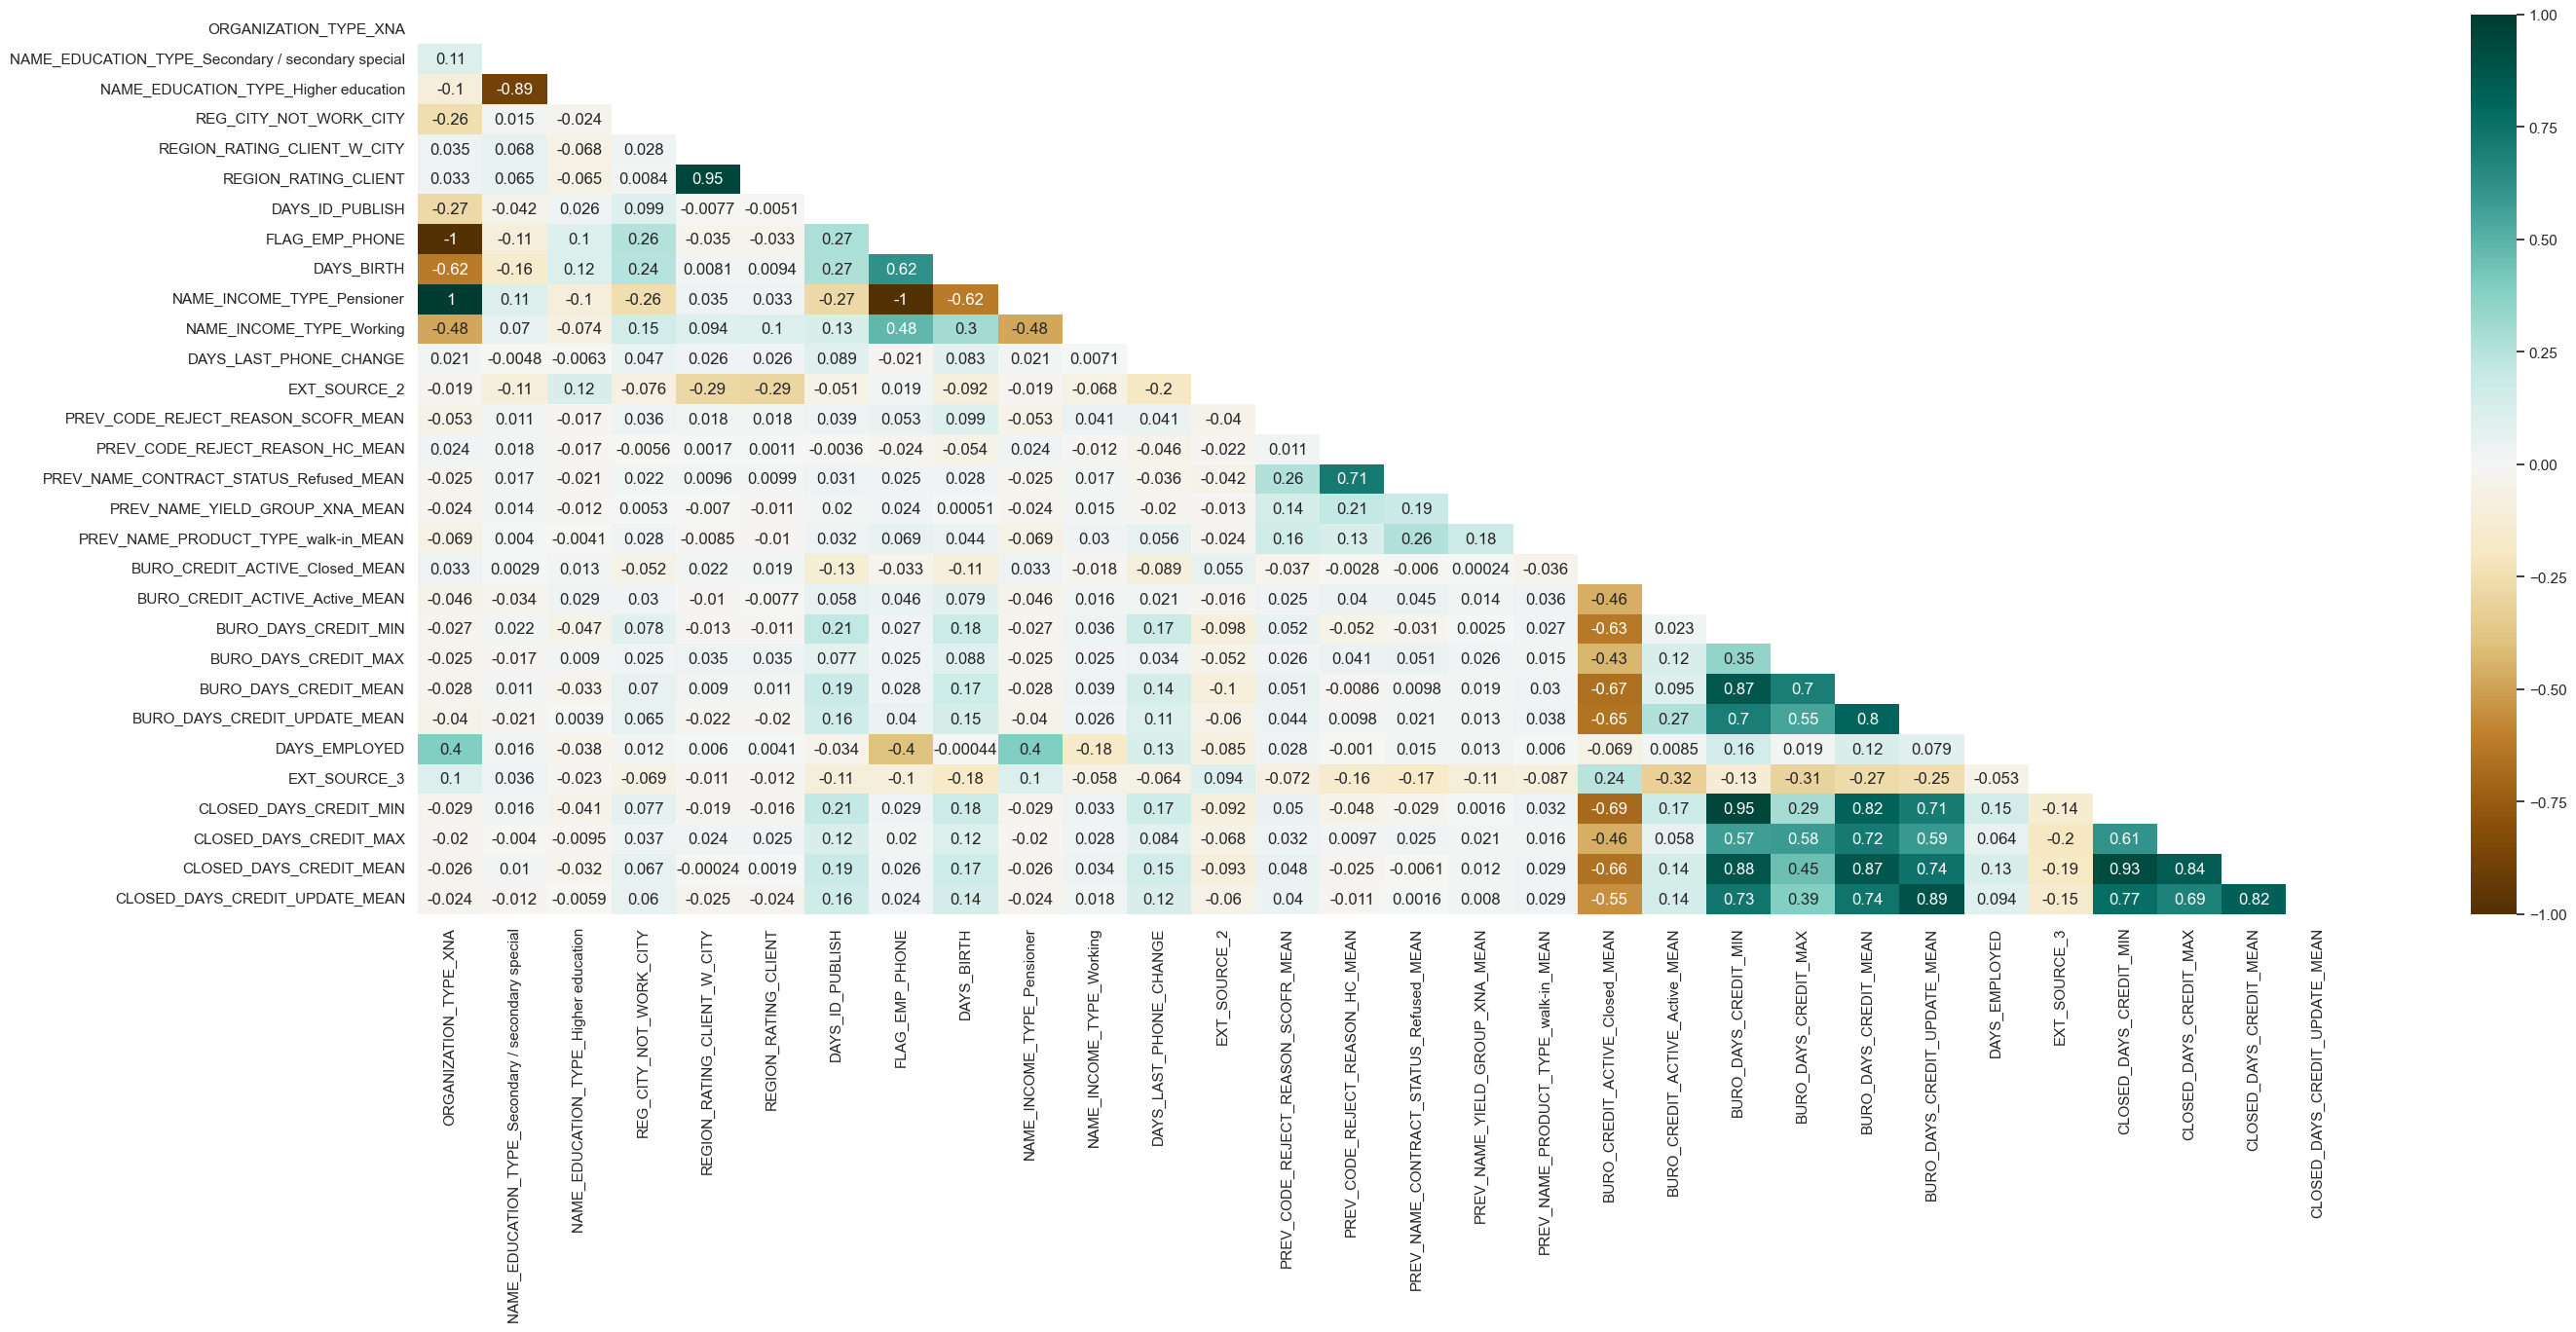

In [152]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(32, 12))
mask = np.triu(np.ones_like(df_train_final_nona.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_train_final_nona.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Certaines variables sont totalement corrélées entre elles, nous allons donc supprimer :
- 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE_XNA' et conserver 'NAME_INCOME_TYPE_Pensionner'

D'autres sont fortements corrélées :
- REGION_RATING_CLIENT et REGION_RATING_CLIENT_W_CITY sont trés corréles, nous conservons REGION_RATING_CLIENT_W_CITY car la ville et la région sont prises en compte (+précis)  
- BURO_DAYS_CREDIT_MAX et BURO_DAYS_CREDIT_MIN   
- CLOSED_DAYS_CREDIT_MIN et CLOSED_DAYS_CREDIT_MEAN

In [153]:
total_features = list(set(features_30) - set(['FLAG_EMP_PHONE', 'ORGANIZATION_TYPE_XNA', 'REGION_RATING_CLIENT', 'BURO_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MIN']))

## Stratégie pour les valeurs manquantes

Nous devons trouver une méthode pour remplir les valeurs manquantes, nous allons suivre la même démarche que dans la section select Kbest, nous conservons alors la liste des features pour un prochaine utilisation.

In [154]:
total_features= [
                 'BURO_DAYS_CREDIT_MAX',
                 'NAME_INCOME_TYPE_Pensioner',
                 'PREV_NAME_YIELD_GROUP_XNA_MEAN',
                 'BURO_DAYS_CREDIT_UPDATE_MEAN',
                 'BURO_DAYS_CREDIT_MEAN',
                 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
                 'BURO_CREDIT_ACTIVE_Closed_MEAN',
                 'EXT_SOURCE_3',
                 'PREV_CODE_REJECT_REASON_HC_MEAN',
                 'EXT_SOURCE_2',
                 'DAYS_BIRTH',
                 'NAME_EDUCATION_TYPE_Secondary / secondary special',
                 'CLOSED_DAYS_CREDIT_MEAN',
                 'REG_CITY_NOT_WORK_CITY',
                 'DAYS_EMPLOYED',
                 'BURO_CREDIT_ACTIVE_Active_MEAN',
                 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
                 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
                 'CLOSED_DAYS_CREDIT_MAX',
                 'REGION_RATING_CLIENT_W_CITY',
                 'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
                 'NAME_EDUCATION_TYPE_Higher education',
                 'NAME_INCOME_TYPE_Working',
                 'DAYS_ID_PUBLISH']

In [155]:
# df_full resultat des unifications des sorties de fonctions
df_full_feature = df_full[total_features]
df_full_feature['TARGET'] = df_full['TARGET']

Le total des Valeurs manquantes est 787893soit 8.846393734824774 %


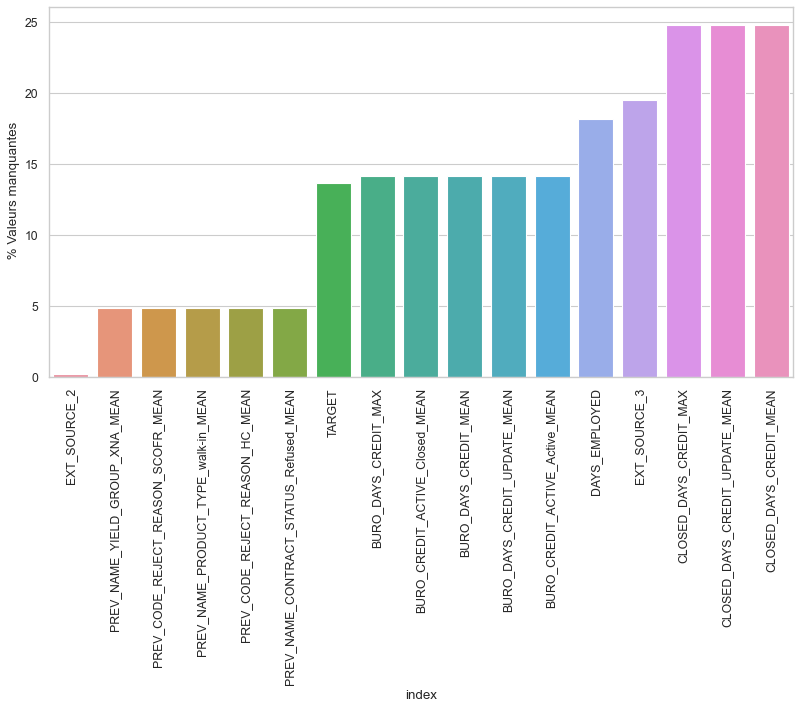

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

tot_val = df_full_feature.shape[0]*df_full_feature.shape[1]
print(f'Le total des Valeurs manquantes est {df_full_feature.isna().sum().sum()}\
soit {df_full_feature.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(df_full_feature.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = df_full_feature.isna().sum()/df_full_feature.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 90)
plt.show()

**Remplir les valeurs manquantes semble être plutot facile :**  
- Les colonnes avec suffixe MEAN / MIN / SUM / MAX / VAR vont être placées à 0 car le manque d'information provient de l'absence de précédent crédits
- Le nombre de jours travaillés 'DAYS_EMPLOYED' est lui aussi placé à 0 car cette information manquante provient sans doute du fait que le client à peu ou pas travaillé  

Les deux autres colonnes seront remplacées par la médiane.

In [157]:
col_fill_0 = []

matches = ['MEAN', 'VAR', 'MAX', 'MIN', 'SUM','DAYS_EMPLOYED']
for col_ in df_full_feature.columns:
  if any(x in col_ for x in matches):
    col_fill_0.append(col_)
    
# df2['Discount'] =  df['Discount'].fillna(0

In [158]:
col_fill_0

['BURO_DAYS_CREDIT_MAX',
 'PREV_NAME_YIELD_GROUP_XNA_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_DAYS_CREDIT_MEAN',
 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'PREV_CODE_REJECT_REASON_HC_MEAN',
 'CLOSED_DAYS_CREDIT_MEAN',
 'DAYS_EMPLOYED',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
 'CLOSED_DAYS_CREDIT_MAX',
 'PREV_CODE_REJECT_REASON_SCOFR_MEAN']

In [159]:
df_full_feature[col_fill_0] = df_full_feature[col_fill_0].fillna(0)

C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Pour finir cette partie nous allons enregistrer notre jeu de données :

In [160]:
df_full_feature.to_csv('data_train_test_30.csv')

Le total des Valeurs manquantes est 119045soit 1.3366268543599389 %


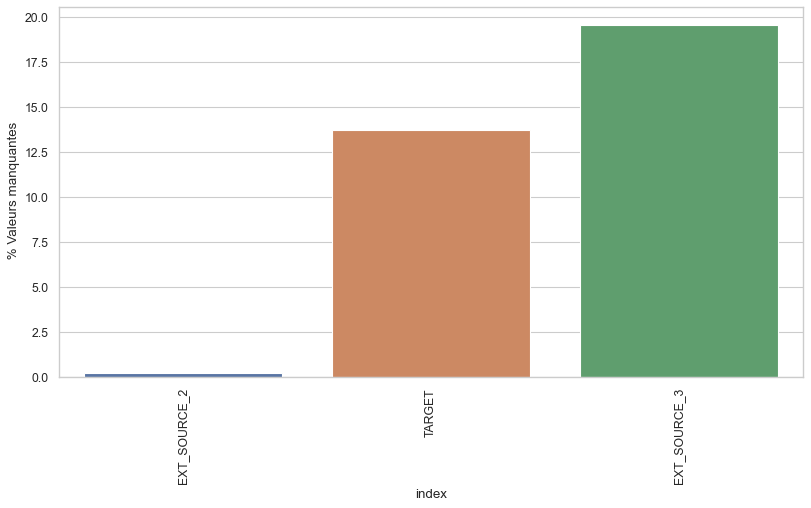

In [161]:
tot_val = df_full_feature.shape[0]*df_full_feature.shape[1]
print(f'Le total des Valeurs manquantes est {df_full_feature.isna().sum().sum()}\
soit {df_full_feature.isna().sum().sum()/tot_val*100} %')
missVal = pd.DataFrame(df_full_feature.isna().sum(), columns = ['Valeurs manquantes'])
missVal[' % Valeurs manquantes'] = df_full_feature.isna().sum()/df_full_feature.shape[0]*100
missVal = missVal.reset_index()
missVal = missVal.sort_values(by = 'Valeurs manquantes')

figure(figsize=(12, 6), dpi=80)
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'index', y = ' % Valeurs manquantes', data=missVal[missVal['Valeurs manquantes']>0])
plt.xticks(rotation = 90)
plt.show()

### Sauvegarde des dataframes de train et test  
Avant de sauvegarder les données nous allons remplir les valeurs manquantes dans le jeu de test à l'aide du train.  
Les valeurs manquantes dans le jeu de train ne sont pas remplacées directement sous peine de data leakage.

In [162]:
df_train_final = df_full_feature[~df_full_feature['TARGET'].isnull()]
df_test_final = df_full_feature[df_full_feature['TARGET'].isnull()]

In [163]:
df_test_final['EXT_SOURCE_2'] = df_test_final['EXT_SOURCE_2'].fillna(df_train_final['EXT_SOURCE_2'].mean())
df_test_final['EXT_SOURCE_3'] = df_test_final['EXT_SOURCE_3'].fillna(df_train_final['EXT_SOURCE_3'].mean())

C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [164]:
df_test_final.drop(columns = 'TARGET', inplace = True)

C:\Users\pouru\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [165]:
df_test_final.to_csv('df_test_final.csv')

In [166]:
df_train_final.to_csv('df_train_final.csv')

In [64]:
data_train = pd.read_csv('df_train_final.csv',  index_col=0)

In [65]:
data_train

BURO_DAYS_CREDIT_MAX  NAME_INCOME_TYPE_Pensioner  \
SK_ID_CURR                                                     
100002                    -103.0                           0   
100003                    -606.0                           0   
100004                    -408.0                           0   
100006                       0.0                           0   
100007                   -1149.0                           0   
...                          ...                         ...   
456251                       0.0                           0   
456252                       0.0                           1   
456253                    -713.0                           0   
456254                   -1104.0                           0   
456255                    -363.0                           0   

            PREV_NAME_YIELD_GROUP_XNA_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                 
100002                            0.000000                   -499.875000   
100003                            0.000000                   -816.000000   
100004                            0.000000                   -532.000000   
100006                            0.444444                      0.000000   
100007                            0.000000                   -783.000000   
...                                    ...                           ...   
456251                            0.000000                      0.000000   
456252                            0.000000                      0.000000   
456253                            0.000000                   -253.250000   
456254                            0.000000                   -401.000000   
456255                            0.125000                   -531.090909   

            BURO_DAYS_CREDIT_MEAN  CLOSED_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                          
100002                -874.000000                     -661.333333   
100003               -1400.750000                    -1073.666667   
100004                -867.000000                     -532.000000   
100006                   0.000000                        0.000000   
100007               -1149.000000                     -783.000000   
...                           ...                             ...   
456251                   0.000000                        0.000000   
456252                   0.000000                        0.000000   
456253                -867.500000                     -414.500000   
456254               -1104.000000                     -401.000000   
456255               -1089.454545                     -954.000000   

            BURO_CREDIT_ACTIVE_Closed_MEAN  EXT_SOURCE_3  \
SK_ID_CURR                                                 
100002                            0.750000      0.139376   
100003                            0.750000           NaN   
100004                            1.000000      0.729567   
100006                            0.000000           NaN   
100007                            1.000000           NaN   
...                                    ...           ...   
456251                            0.000000           NaN   
456252                            0.000000           NaN   
456253                            0.500000      0.218859   
456254                            1.000000      0.661024   
456255                            0.545455      0.113922   

            PREV_CODE_REJECT_REASON_HC_MEAN  EXT_SOURCE_2  ...  \
SK_ID_CURR                                                 ...   
100002                                 0.00      0.262949  ...   
100003                                 0.00      0.622246  ...   
100004                                 0.00      0.555912  ...   
100006                                 0.00      0.650442  ...   
100007                                 0.00      0.322738  ...   
...                                     ...      

In [66]:
data_test = pd.read_csv('df_test_final.csv',  index_col=0)

In [88]:
data_train = pd.read_csv('df_train_final.csv',  index_col=0)

In [93]:

data_train.isna().sum()

BURO_DAYS_CREDIT_MAX                                 0
NAME_INCOME_TYPE_Pensioner                           0
PREV_NAME_YIELD_GROUP_XNA_MEAN                       0
BURO_DAYS_CREDIT_UPDATE_MEAN                         0
BURO_DAYS_CREDIT_MEAN                                0
CLOSED_DAYS_CREDIT_UPDATE_MEAN                       0
BURO_CREDIT_ACTIVE_Closed_MEAN                       0
EXT_SOURCE_3                                         0
PREV_CODE_REJECT_REASON_HC_MEAN                      0
EXT_SOURCE_2                                         0
DAYS_BIRTH                                           0
NAME_EDUCATION_TYPE_Secondary / secondary special    0
CLOSED_DAYS_CREDIT_MEAN                              0
REG_CITY_NOT_WORK_CITY                               0
DAYS_EMPLOYED                                        0
BURO_CREDIT_ACTIVE_Active_MEAN                       0
PREV_NAME_CONTRACT_STATUS_Refused_MEAN               0
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                  0
CLOSED_DAY

In [92]:
data_train = data_train.fillna(data_train.median())

In [94]:
data_train.to_csv('df_full_train_streamlit.csv')

In [70]:
data_test.to_csv('df_full_test_streamlit.csv')

# Classification supervisée

L'objectif et de pouvoir détecter les clients qui pourraient faire défault.  
Nous allons dans cette partie utiliser plusieurs méthodes de classification et selectionner celle avec les meilleurs résultats.  

Comme nous l'avons constater il y n'y a que seulement 8% des clients avec le label 1, ceci peut poser des problèmes quand à l'évaluation de la métriques ainsi que durant l'apprentissage des modèles.  
Pour palier ce problème plusieurs méthodes s'offrent à nous :  
- Modifier le jeu d'entrainement pour équilibrer les classes :  
    - Faire de l'over-sampling (créer de nouveaux échantillons de la classe la moins présente
    - Faire de l'under sampling (supprimer des éléments de la classe la plus présente)
    
Nous allons effectuer plusieurs tests avec des modèles et paramatres différents pour ces deux méthodes.  
Le modèle le plus performant sera retenu et nous utiliserons le module Hyperopt pour déterminer encore plus précisément les meilleurs hyperparamètres.


In [26]:
import pandas as pd
import numpy as np
data_train = pd.read_csv('df_train_final.csv')

In [27]:
data_train.set_index('SK_ID_CURR', inplace = True)

In [28]:
data_train

BURO_DAYS_CREDIT_MAX  NAME_INCOME_TYPE_Pensioner  \
SK_ID_CURR                                                     
100002                    -103.0                           0   
100003                    -606.0                           0   
100004                    -408.0                           0   
100006                       0.0                           0   
100007                   -1149.0                           0   
...                          ...                         ...   
456251                       0.0                           0   
456252                       0.0                           1   
456253                    -713.0                           0   
456254                   -1104.0                           0   
456255                    -363.0                           0   

            PREV_NAME_YIELD_GROUP_XNA_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                 
100002                            0.000000                   -499.875000   
100003                            0.000000                   -816.000000   
100004                            0.000000                   -532.000000   
100006                            0.444444                      0.000000   
100007                            0.000000                   -783.000000   
...                                    ...                           ...   
456251                            0.000000                      0.000000   
456252                            0.000000                      0.000000   
456253                            0.000000                   -253.250000   
456254                            0.000000                   -401.000000   
456255                            0.125000                   -531.090909   

            BURO_DAYS_CREDIT_MEAN  CLOSED_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                          
100002                -874.000000                     -661.333333   
100003               -1400.750000                    -1073.666667   
100004                -867.000000                     -532.000000   
100006                   0.000000                        0.000000   
100007               -1149.000000                     -783.000000   
...                           ...                             ...   
456251                   0.000000                        0.000000   
456252                   0.000000                        0.000000   
456253                -867.500000                     -414.500000   
456254               -1104.000000                     -401.000000   
456255               -1089.454545                     -954.000000   

            BURO_CREDIT_ACTIVE_Closed_MEAN  EXT_SOURCE_3  \
SK_ID_CURR                                                 
100002                            0.750000      0.139376   
100003                            0.750000           NaN   
100004                            1.000000      0.729567   
100006                            0.000000           NaN   
100007                            1.000000           NaN   
...                                    ...           ...   
456251                            0.000000           NaN   
456252                            0.000000           NaN   
456253                            0.500000      0.218859   
456254                            1.000000      0.661024   
456255                            0.545455      0.113922   

            PREV_CODE_REJECT_REASON_HC_MEAN  EXT_SOURCE_2  ...  \
SK_ID_CURR                                                 ...   
100002                                 0.00      0.262949  ...   
100003                                 0.00      0.622246  ...   
100004                                 0.00      0.555912  ...   
100006                                 0.00      0.650442  ...   
100007                                 0.00      0.322738  ...   
...                                     ...      

In [4]:
data_X = data_train.drop(columns = 'TARGET')
data_y = data_train['TARGET']

## Selection du meilleur modèle

Le but est dans un premier temps de spot-checker le modèle qui donne les meilleurs résultats en utilisant ou non des méthodes de resampling. Nous utiliserons quelques paramètres pricipaux des modèles pour ne pas avoir de temps de calcul trop important car nous utiliserons une validation coisée.
Métrique d'évaluation : 
La métrique AUR sera utilisée pour évaluer la performance des modèles, puisque les classes sont inégalement distribuées utilisé des métriques comme l'accuracy ou la précision ne serait pas adapté car nous aurions de très bon scores (~92%) sans utiliser de méthode resampling avec un classifier assignant toujours la classe 0.  

Une alternative serait d'utiliser le recall car notre véritable objectif et de détecter de manière fiable les vrais positif (soit les clients qui ne vont pas honorer leur crédit). Mais cette approche d'un point de vu métier sera traitée dans la partie suivante.

In [4]:
# import des librairies
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
from sklearn import cluster, metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

## Les figures sont réalisées avec Plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from   plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

# Modèles de ML
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet

### Données de validation  
L'idée est ici d'isoler une partie des données, cette partie ne sera pas utilisée dans le procéssus de cross validation et permettra de comparer les résultats une fois le modèle final optenu.

In [29]:
data_train_test, data_valid= train_test_split(data_train, test_size=0.2, random_state=1)

### Création des folds : une cross validation manuelle ?

Nous allons utiliser une cross validation manuelle, en effet le ressampling ne doit pas être effectué avant la cross validation mais pendent car :

on va créer des éléments dans le jeu de train qui vont être trés proches de ceux utilisés dans le jeu de test, d'autre part (encore plus grave) on va évaluer la performance sur des données fictives (ex: un algoritme type KNN pourait anormalement bien performer).



In [95]:
from sklearn import model_selection
data_train_test.reset_index(drop = True, inplace = True)
data_train_test["kfold"] = -1

# for loop to create the k-folds
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=data_train_test)):
    data_train_test.loc[valid_indicies, "kfold"] = fold



cv_train = []
cv_test = []
total_index = set(data_train_test.index.values)
for i in range(5):
  mask = data_train_test['kfold'] == i
  remove_index = data_train_test[mask].index.values
  keep_index = total_index -  set(remove_index)
  cv_test.append(data_train_test.loc[remove_index, :].drop(columns = ["kfold"]))
  cv_train.append(data_train_test.loc[keep_index, :].drop(columns = ["kfold"]))


# Valeurs manquantes
for i in range(len(cv_train)):
  median_cols = cv_train[i].median()
  cv_train[i].fillna(median_cols, inplace = True)
  cv_test[i].fillna(median_cols, inplace = True)

In [102]:
cv_train_X_tl = []
cv_train_Y_tl = []
for i in range(len(cv_train)):
  print(i)
  tl = TomekLinks(n_jobs= 1)
  X_res, y_res = tl.fit_resample(cv_train[i].iloc[:,:-1], cv_train[i].iloc[:,-1])
  cv_train_X_tl.append(X_res)
  cv_train_Y_tl.append(y_res)

cv_train_X_smote = []
cv_train_Y_smote = []
for i in range(len(cv_train)):
  smote = SMOTE(n_jobs= 1)
  X_res, y_res = smote.fit_resample(cv_train[i].iloc[:,:-1], cv_train[i].iloc[:,-1])
  cv_train_X_smote.append(X_res)
  cv_train_Y_smote.append(y_res)
    
cv_train_X_smote[0]['TARGET'] = cv_train_Y_smote[0]
cv_train_X_smote[1]['TARGET'] = cv_train_Y_smote[1]
cv_train_X_smote[2]['TARGET'] = cv_train_Y_smote[2]
cv_train_X_smote[3]['TARGET'] = cv_train_Y_smote[3]
cv_train_X_smote[4]['TARGET'] = cv_train_Y_smote[4]

cv_train_X_smote[0].to_csv('cv_train_X_smote_1.csv')
cv_train_X_smote[1].to_csv('cv_train_X_smote_2.csv')
cv_train_X_smote[2].to_csv('cv_train_X_smote_3.csv')
cv_train_X_smote[3].to_csv('cv_train_X_smote_4.csv')
cv_train_X_smote[4].to_csv('cv_train_X_smote_5.csv')

cv_train_X_tl[0]['TARGET'] = cv_train_Y_tl[0]
cv_train_X_tl[1]['TARGET'] = cv_train_Y_tl[1]
cv_train_X_tl[2]['TARGET'] = cv_train_Y_tl[2]
cv_train_X_tl[3]['TARGET'] = cv_train_Y_tl[3]
cv_train_X_tl[4]['TARGET'] = cv_train_Y_tl[4]

cv_train_X_tl[0].to_csv('cv_train_X_tl_1.csv')
cv_train_X_tl[1].to_csv('cv_train_X_tl_2.csv')
cv_train_X_tl[2].to_csv('cv_train_X_tl_3.csv')
cv_train_X_tl[3].to_csv('cv_train_X_tl_4.csv')
cv_train_X_tl[4].to_csv('cv_train_X_tl_5.csv')

cv_test[0].to_csv('cv_test_1.csv')
cv_test[1].to_csv('cv_test_2.csv')
cv_test[2].to_csv('cv_test_3.csv')
cv_test[3].to_csv('cv_test_4.csv')
cv_test[4].to_csv('cv_test_5.csv')

cv_train[0].to_csv('cv_train_1.csv')
cv_train[1].to_csv('cv_train_2.csv')
cv_train[2].to_csv('cv_train_3.csv')
cv_train[3].to_csv('cv_train_4.csv')
cv_train[4].to_csv('cv_train_5.csv')




0
1
2
3
4


In [3]:
#### Lecture des fichiers enregistrés  
#Nous avons enregistré les jeux de cross validation après les méthodes de ressampling pour économiser
#du temps sur l'utilisation successive du notebook

import pandas as pd

cv_test = []
cv_train = []
cv_train_X_tl = []
cv_train_X_smote = []

for i in range(5):
    cv_test_root = 'cv_test_'+str(i+1)+'.csv'
    cv_train_root = 'cv_train_'+str(i+1)+'.csv'
    cv_train_X_tl_root = 'cv_train_X_tl_' +str(i+1)+ '.csv'
    cv_train_X_smote_root = 'cv_train_X_smote_' +str(i+1)+ '.csv'
    
    cv_test.append(pd.read_csv(cv_test_root, index_col=[0]))
    cv_train.append(pd.read_csv(cv_train_root, index_col=[0]))
    cv_train_X_tl.append(pd.read_csv(cv_train_X_tl_root, index_col=[0]))
    cv_train_X_smote.append(pd.read_csv(cv_train_X_smote_root, index_col=[0]))
    
    

**Note importante**

le code ci dessous permet l'utilisation d'un pipline spécifique à l'utilisation des méthodes de resampling.    
Le problème est que pour chaque paramètre / modèle durant grid search CV le ressampling et à nouveau effectué, ce qui fait perdre énormément de temps.  
Il ne faut pas effectuer le ressempling avant le processus de crossvalidation pour des raisons évidentes de dataleakage.

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

pipeline = Pipeline(steps = [
        ('imputer', imputer),
        ('sampling', TomekLinks()),
        ('classifier', clf1)])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

gs = GridSearchCV(pipeline, params, scoring='roc_auc', n_jobs = 1, verbose = 10, cv=stratified_kfold)
gs.fit(data_X, data_y)

### Le module hyperopt pour la cross validation manuelle 

Nous utilisons le module hyper opt pour mener à bien cette valisation croisée.  
Ci-dessous le code comprend deux fonctions : 
- **build_space** définit l'espace des modèles / paramètres, prenant en argument les folds train et test (avec ou sans méthode de resampling)
- **find_best_model** validation croisée manuelle, boucle sur les folds et récupération des scores.

**Une petite astuce :** des petits test ont été réalisés et nous avons obtenu un score AUC de 0.7, c'est pourquoi si sur un des fold de test le score est inférieur à 0.7 alors la cross validation s'arête.   
-> economie de temps de calcul sur des combinaisons modèles/paramètres que nous n'allons pas retenir.

In [118]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp, STATUS_FAIL
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
def build_space(cv_train, cv_test):
    space = {
        'model' : hp.choice('model', 
                            [
                              {'name' : 'reg_log',
                              'params': {
                                  'penalty' : hp.choice('rl1',['none', 'l2']),
                                  'C' : hp.choice('rl2',[100, 10, 1.0, 0.1, 0.01])
                                        }
                              },
                             {'name' : 'RF',
                              'params': {
                                          'max_depth':  hp.choice('max_depthr', [5, 15, 50, 100, None]),
                                          'min_samples_leaf':  hp.choice('min_samples_leafr', [1, 2, 4, 8]),
                                          'min_samples_split': hp.choice('min_samples_splitr', [2, 5, 8]),
                                          'n_estimators':  hp.choice('n_estimatorsr', [10, 30, 60])#,100])
                                        }
                              } ,
                             {'name' : 'XGBOOST',
                              'params' :{ 
                                          'max_depth':  hp.choice('max_depthx', [5, 15, 50, 100, None]),
                                          'min_samples_leaf':  hp.choice('min_samples_leafx', [1, 2, 4, 8]),
                                          'min_samples_split': hp.choice('min_samples_splitx', [2, 5, 8]),
                                          'n_estimators':  hp.choice('n_estimatorsx', [10, 30, 60]),#, 100]),
                                          #'learning_rate' : [0.001, 0.01, 0.1, 0.3]
                                        }
                             },
                             ]),
        
        'cv_train' : cv_train,
        'cv_test' : cv_test,

        }


    return space


from sklearn import metrics

def find_best_model(space):
  cv_train = space['cv_train']
  cv_test = space['cv_test']
  cv_params_model = space['model']['params']
  classifiers = { 'reg_log': LogisticRegression(),
                'RF': RandomForestClassifier(),
                'XGBOOST': XGBClassifier(),
                }
  try : 
      aucs = []
      precision_s = []
      recall_s = []
      accuracy_s = []
      mean_fpr = np.linspace(0, 1, 100)
      for i in range(len(cv_train)) :
        model =  classifiers[space['model']['name']]
        model.set_params(**cv_params_model)
        train_X = cv_train[i].iloc[:,:-1]
        train_y = cv_train[i].iloc[:,-1]

        test_X = cv_test[i].iloc[:,:-1]
        test_y = cv_test[i].iloc[:,-1]

        model.fit(train_X, train_y)

        y_pred_proba = model.predict_proba(test_X)[:, 1]
        y_pred =  model.predict(test_X)
        
        auc_ = metrics.roc_auc_score(test_y, y_pred_proba)
        aucs.append(auc_)
        precision_s.append(precision_score(test_y, y_pred))
        recall_s.append(recall_score(test_y, y_pred))
        accuracy_s.append(accuracy_score(test_y, y_pred))
        # petite astuce très sympas (on ne continue pas la cv)
        if auc_ < 0.7 :
            break

      mean_auc = np.mean(aucs)
      std_auc = np.std(aucs)
      mean_preci = np.mean(precision_s)
      mean_recall = np.mean(recall_s)
      mean_accuracy = np.mean(accuracy_s)
        

      # On calcule au passage le df error par curiosité
      #y_predict = model.predict(X_test).reshape(len(X_test),n_step_out,len(target_names))
      #df_error = make_df_error_mtso(target_names, y_test, y_predict)
      return {'loss': - mean_auc, 'status': STATUS_OK, 'model': model, 'params': space, 'std_auc' : std_auc, 'precision' : mean_preci, 'recall' : mean_recall, 'accuracy_s' : mean_accuracy}
  except : 
      return {'loss': None, 'status': STATUS_FAIL, 'model': 'Error', 'params': space, 'std_auc' : 'Error', 'precision' : 'Error', 'recall' : 'Error', 'accuracy_s' : 'Error'}
    


### Sans méthode de resampling

In [4]:
import warnings

# Masque les avertissements
warnings.filterwarnings("ignore")


space = build_space(cv_train, cv_test)
trials_base = Trials()

best_base = fmin(find_best_model,
            space,
            algo=tpe.suggest,
            max_evals= 100,
            trials=trials_base)

[02:03:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:04:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:07:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:12:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:12:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:12:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:17:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:17:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:17:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:20:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:23:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:24:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:32:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:38:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:38:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:38:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:41:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:41:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:41:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:54:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:54:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:54:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:55:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:56:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:56:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:57:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:57:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:57:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:58:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:59:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:59:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:00:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:00:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:00:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:02:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:02:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:03:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:04:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:04:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:04:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:09:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:12:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:14:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:15:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:17:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:20:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:20:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:21:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:23:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:23:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:23:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:31:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:31:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:31:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:32:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:32:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:32:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:36:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:36:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:36:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:40:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:40:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:42:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:44:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:44:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:44:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:46:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:46:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:46:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:55:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:55:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:55:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:56:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:56:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:56:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:58:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:02:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:02:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:03:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:04:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:04:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:04:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:05:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:06:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:06:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:07:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:08:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:08:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:08:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:09:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:11:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:11:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:11:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:17:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:17:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:17:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:18:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:18:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:19:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:20:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:20:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:24:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:28:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:28:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:28:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:30:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:30:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:30:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:31:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:31:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:31:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:40:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:40:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:40:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:43:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:43:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:43:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:45:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:45:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:47:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:48:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:48:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

In [ ]:
nb_try = len(trials_base.results)


loss_trials = [trials_base.results[i]['loss'] for i in range(nb_try)]
loss_std_trials = [trials_base.results[i]['std_auc'] for i in range(nb_try)]
loss_preci = [trials_base.results[i]['precision'] for i in range(nb_try)]
loss_recall = [trials_base.results[i]['recall'] for i in range(nb_try)]
loss_accu = [trials_base.results[i]['accuracy_s'] for i in range(nb_try)] 
model_name_trials = [trials_base.results[i]['params']['model']['name'] for i in range(nb_try)]
model_params = [trials_base.results[i]['params']['model']['params'] for i in range(nb_try)]

d = {
    'auc' : loss_trials,
    'std_auc' : loss_std_trials,
    'preci' : loss_preci,
    'recall' : loss_recall,
    'accuracy' : loss_accu,
    'model name' : model_name_trials,
    'params' : model_params
    }
recap_hyper_opt_base = pd.DataFrame(d)
recap_hyper_opt_base.dropna(inplace = True)
recap_hyper_opt_base.sort_values(by = 'auc')

In [9]:
recap_hyper_opt_base['auc'] = - recap_hyper_opt_base['auc']
recap_hyper_opt_base['sampling'] = 'sans'
recap_hyper_opt_base.to_csv('recap_hyper_opt_base.csv')

### Undersampling

Ici l'objectif est de supprimer des éléments de la classe 0.    
Les Tomek-links sont des paires d'instances très proches mais de classes opposées. La suppression des instances de la classe majoritaire de chaque paire augmente l'espace entre les deux classes, ce qui facilite le processus de classification.

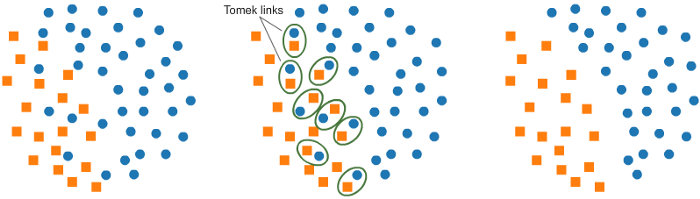

In [66]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("tomeklinks.png")

In [ ]:
import warnings

# Masque les avertissements
warnings.filterwarnings("ignore")


space = build_space(cv_train_X_tl, cv_test)
trials1 = Trials()

best1_tl = fmin(find_best_model,
            space,
            algo=tpe.suggest,
            max_evals= 100,
            trials=trials1)

In [ ]:
nb_try = len(trials1.results)


loss_trials = [trials1.results[i]['loss'] for i in range(nb_try)]
loss_std_trials = [trials1.results[i]['std_auc'] for i in range(nb_try)]
loss_preci = [trials1.results[i]['precision'] for i in range(nb_try)]
loss_recall = [trials1.results[i]['recall'] for i in range(nb_try)]
loss_accu = [trials1.results[i]['accuracy_s'] for i in range(nb_try)] 
model_name_trials = [trials1.results[i]['params']['model']['name'] for i in range(nb_try)]
model_params = [trials1.results[i]['params']['model']['params'] for i in range(nb_try)]

d = {
    'auc' : loss_trials,
    'std_auc' : loss_std_trials,
    'preci' : loss_preci,
    'recall' : loss_recall,
    'accuracy' : loss_accu,
    'model name' : model_name_trials,
    'params' : model_params
    }
recap_hyper_opt_TL = pd.DataFrame(d)
recap_hyper_opt_TL.dropna(inplace = True)
recap_hyper_opt_TL.sort_values(by = 'auc')

In [ ]:
recap_hyper_opt_TL['auc'] = - recap_hyper_opt_TL['auc']
recap_hyper_opt_TL.to_csv('recap_hyper_opt_TL.csv')

In [14]:
recap_hyper_opt_TL['sampling'] = 'Tomek Link'

In [6]:
recap_hyper_opt_TL = pd.read_csv('recap_hyper_opt_TL.csv')

### Oversampling

L'objectif est ici de créer de nouveaux éléments de la classe 1

SMOTE (Synthetic Minority Oversampling Technique) fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k voisins les plus proches de ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

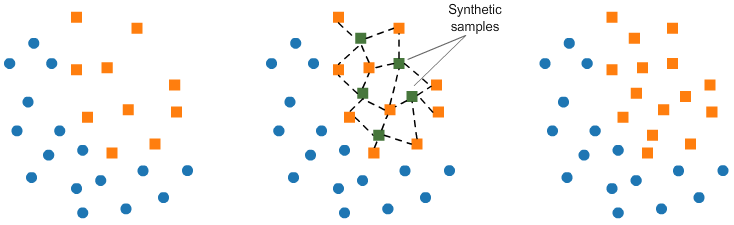

In [73]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("smote.png")

In [ ]:
space2 = build_space(cv_train_X_smote, cv_test)
trials2 = Trials()

best1_t2 = fmin(find_best_model,
            space2,
            algo=tpe.suggest,
            max_evals= 100,
            trials=trials2)

In [ ]:
nb_try = len(trials2.results)


loss_trials = [trials2.results[i]['loss'] for i in range(nb_try)]
loss_std_trials = [trials2.results[i]['std_auc'] for i in range(nb_try)]
loss_preci = [trials2.results[i]['precision'] for i in range(nb_try)]
loss_recall = [trials2.results[i]['recall'] for i in range(nb_try)]
loss_accu = [trials2.results[i]['accuracy_s'] for i in range(nb_try)] 
model_name_trials = [trials2.results[i]['params']['model']['name'] for i in range(nb_try)]
model_params = [trials2.results[i]['params']['model']['params'] for i in range(nb_try)]

d = {
    'auc' : loss_trials,
    'std_auc' : loss_std_trials,
    'preci' : loss_preci,
    'recall' : loss_recall,
    'accuracy' : loss_accu,
    'model name' : model_name_trials,
    'params' : model_params
    }
recap_hyper_opt_SM = pd.DataFrame(d)
recap_hyper_opt_SM.dropna(inplace = True)
recap_hyper_opt_SM.sort_values(by = 'auc')

In [21]:
recap_hyper_opt_SM.to_csv('recap_hyper_opt_SM.csv')

In [22]:
recap_hyper_opt_SM = pd.read_csv('recap_hyper_opt_SM.csv')

In [18]:
recap_hyper_opt_SM['sampling'] = 'SMOTE'

In [41]:
recap_hyper_opt_SM['auc'] = - recap_hyper_opt_SM['auc']

### Récapitulatif des scores

In [ ]:
Nous pouvons alors agréger les résultats de hyperopt

In [43]:
recap_hyper_opt_all = pd.concat([recap_hyper_opt_base, recap_hyper_opt_TL,recap_hyper_opt_SM ])

In [44]:
recap_hyper_opt_all.to_csv('recap_hyper_opt_all.csv')

<AxesSubplot:xlabel='model name', ylabel='auc'>

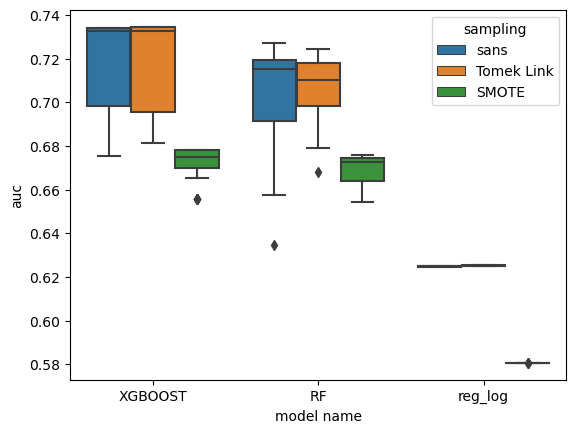

In [50]:
sns.boxplot(data=recap_hyper_opt_all, x="model name", y="auc", hue = 'sampling')

<AxesSubplot:xlabel='model name', ylabel='recall'>

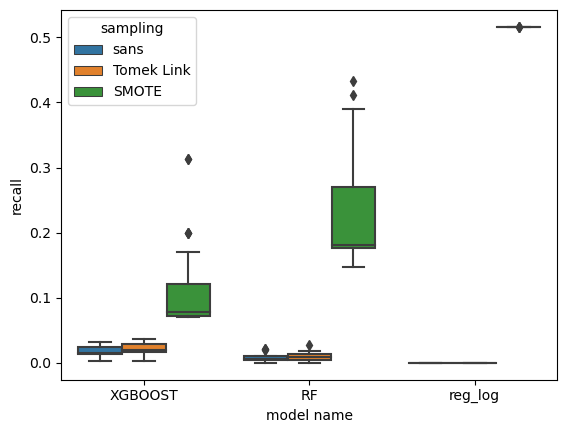

In [49]:
sns.boxplot(data=recap_hyper_opt_all, x="model name", y="recall", hue = 'sampling')

#### Meilleurs résultats pour l'auc

In [64]:
recap_hyper_opt_all.sort_values(by = 'auc').iloc[-1,:]

auc                                                    0.734565
std_auc                                                0.002107
preci                                                  0.492992
recall                                                 0.016652
accuracy                                               0.919251
model name                                              XGBOOST
params        {'max_depth': 5, 'min_samples_leaf': 4, 'min_s...
sampling                                             Tomek Link
Name: 73, dtype: object

In [65]:
recap_hyper_opt_all.sort_values(by = 'auc').iloc[-1,:]['params']

"{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}"

In [56]:
recap_hyper_opt_all['auc'].max()

0.7345654905940504

### Hyper optimisation du meilleur modèle  


Nous avons identifié le meilleur modèle à utiliser était XGboost en utilisant la méthode Tomek-link.   
Nous allons alors faire une hyper optimasation fine des paramètres en prenant en compte les hyper paramètres que nous avions identifiés précédemment.

In [7]:

from hyperopt import Trials, STATUS_OK, tpe, fmin, hp, STATUS_FAIL
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
def build_space2(cv_train, cv_test):
    space = {
        'model' : hp.choice('model', 
                            [
                        
                             {'name' : 'XGBOOST',
                              'params' :{ 
                                          'max_depth':  hp.choice('max_depthx', np.arange(2,10)),
                                          'min_samples_leaf':  hp.choice('min_samples_leafx', np.arange(2,8)),
                                          'min_samples_split': hp.choice('min_samples_splitx', np.arange(2,5)),
                                          'n_estimators':  hp.choice('n_estimatorsx',np.arange(25,45)),#, 100]),
                                          #'learning_rate' : hp.choice('learning_rate2',[0.01, 0.1, 0.5])
                                        }
                             },
                             ]),
        
        'cv_train' : cv_train,
        'cv_test' : cv_test,

        }


    return space


from sklearn import metrics

def find_best_model2(space):
  cv_train = space['cv_train']
  cv_test = space['cv_test']
  cv_params_model = space['model']['params']
  classifiers = {
                'XGBOOST': XGBClassifier(),
                }
  try : 
      aucs = []
      precision_s = []
      recall_s = []
      accuracy_s = []
      mean_fpr = np.linspace(0, 1, 100)
      for i in range(len(cv_train)) :
        model =  classifiers[space['model']['name']]
        model.set_params(**cv_params_model)
        train_X = cv_train[i].iloc[:,:-1]
        train_y = cv_train[i].iloc[:,-1]

        test_X = cv_test[i].iloc[:,:-1]
        test_y = cv_test[i].iloc[:,-1]

        model.fit(train_X, train_y)

        y_pred_proba = model.predict_proba(test_X)[:, 1]
        y_pred =  model.predict(test_X)
        
        auc_ = metrics.roc_auc_score(test_y, y_pred_proba)
        aucs.append(auc_)
        precision_s.append(precision_score(test_y, y_pred))
        recall_s.append(recall_score(test_y, y_pred))
        accuracy_s.append(accuracy_score(test_y, y_pred))
        # petite astuce très sympas (on ne continue pas la cv)
        if auc_ < 0.7 :
            break

      mean_auc = np.mean(aucs)
      std_auc = np.std(aucs)
      mean_preci = np.mean(precision_s)
      mean_recall = np.mean(recall_s)
      mean_accuracy = np.mean(accuracy_s)
        

      # On calcule au passage le df error par curiosité
      #y_predict = model.predict(X_test).reshape(len(X_test),n_step_out,len(target_names))
      #df_error = make_df_error_mtso(target_names, y_test, y_predict)
      return {'loss': - mean_auc, 'status': STATUS_OK, 'model': model, 'params': space, 'std_auc' : std_auc, 'precision' : mean_preci, 'recall' : mean_recall, 'accuracy_s' : mean_accuracy}
  except : 
      return {'loss': None, 'status': STATUS_FAIL, 'model': 'Error', 'params': space, 'std_auc' : 'Error', 'precision' : 'Error', 'recall' : 'Error', 'accuracy_s' : 'Error'}
    


In [9]:
import warnings
warnings.filterwarnings("ignore")


space = build_space2(cv_train_X_tl, cv_test)
trials1_final = Trials()

best1_tl = fmin(find_best_model2,
            space,
            algo=tpe.suggest,
            max_evals= 300,
            trials=trials1_final)

[01:22:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:22:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:22:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:25:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:25:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:25:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:28:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:28:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:30:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:30:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:30:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:32:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:32:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:32:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:34:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:34:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:34:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:36:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:36:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:36:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:38:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:39:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:39:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:40:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:41:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:41:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:43:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:43:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:43:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:44:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:44:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:44:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:46:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:46:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:46:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:46:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:47:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:47:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:47:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:47:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:47:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:48:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:48:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:49:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:49:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:49:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:51:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:52:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:52:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:52:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:54:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:54:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:54:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:56:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:56:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:56:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:57:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:57:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:57:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[01:58:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:58:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:58:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:00:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:01:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:01:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:02:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:03:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:03:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:03:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:04:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:04:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:05:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:06:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:06:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:07:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:07:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:07:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:09:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:10:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:10:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:10:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:11:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:12:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:12:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:13:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:13:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:13:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:14:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:14:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:14:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:16:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:17:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:17:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:18:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:20:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:20:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:21:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:21:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:21:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:22:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:22:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:22:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:23:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:25:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:27:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:28:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:30:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:31:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:31:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:31:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:33:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:33:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:33:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:33:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:34:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:34:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:36:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:36:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:36:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:38:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:38:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:38:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:39:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:39:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:39:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:40:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:40:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:40:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:41:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:41:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:41:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:43:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:43:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:43:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:45:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:45:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:45:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:46:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:46:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:46:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:48:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:48:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:48:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:49:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:49:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:49:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:50:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:50:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:50:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:52:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:52:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:52:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:53:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:53:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:55:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:55:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:55:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:56:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:56:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:56:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:57:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:58:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:58:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[02:59:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:59:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:59:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:01:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:01:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:01:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:03:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:03:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:03:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:04:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:04:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:04:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:06:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:06:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:06:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:07:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:08:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:08:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:08:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:08:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:08:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:11:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:11:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:11:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:12:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:12:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:12:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:13:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:13:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:13:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:14:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:15:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:15:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:16:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:17:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:17:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:18:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:18:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:18:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:20:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:20:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:20:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:21:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:22:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:22:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:24:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:24:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:24:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:25:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:26:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:26:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:27:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:27:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:29:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:29:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:29:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:30:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:30:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:30:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:31:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:31:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:31:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:33:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:33:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:33:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:34:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:34:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:34:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:36:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:36:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:36:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:37:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:37:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:38:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:38:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:38:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:40:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:40:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:40:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:42:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:42:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:42:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:43:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:43:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:43:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:45:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:45:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:45:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:46:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:46:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:46:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:47:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:47:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:47:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:49:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:50:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:50:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:51:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:51:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:51:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:52:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:52:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:52:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:53:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:55:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:55:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:55:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:56:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:56:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:56:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[03:58:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:00:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:00:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:00:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:01:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:01:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:01:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:02:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:02:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:02:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:04:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:04:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:04:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:05:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:06:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:07:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:07:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:08:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:08:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:08:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:09:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:11:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:11:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:11:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:12:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:12:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:12:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:13:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:13:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:13:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:15:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:15:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:15:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:17:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:17:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:17:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:18:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:18:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:18:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:19:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:19:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:19:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:20:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:21:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:21:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:22:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:22:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:22:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:23:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:23:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:23:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:25:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:25:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:25:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:27:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:27:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:27:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:28:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:28:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:29:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:29:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:29:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:31:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:31:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:31:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:32:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:33:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:33:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:34:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:34:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:34:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:36:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:36:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:36:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:38:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:38:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:38:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:39:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:39:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:39:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:40:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:40:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:40:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:41:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:41:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:41:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:41:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:41:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:41:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:42:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:42:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:42:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:43:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:43:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:43:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:44:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:44:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:44:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:46:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:46:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:46:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:46:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:47:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:47:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:48:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:48:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:48:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:50:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:50:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:50:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:52:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:52:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:52:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:53:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:55:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:55:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:55:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:56:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:56:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:56:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[04:57:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:58:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:58:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[05:00:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:00:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:00:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[05:01:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:01:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:01:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[05:02:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:02:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:02:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

[05:03:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:03:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:03:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_relea

100%|███████████████████████████████████████████| 300/300 [3:42:21<00:00, 44.47s/trial, best loss: -0.7351180987407855]


In [ ]:
nb_try = len(trials1_final.results)


loss_trials = [trials1_final.results[i]['loss'] for i in range(nb_try)]
loss_std_trials = [trials1_final.results[i]['std_auc'] for i in range(nb_try)]
loss_preci = [trials1_final.results[i]['precision'] for i in range(nb_try)]
loss_recall = [trials1_final.results[i]['recall'] for i in range(nb_try)]
loss_accu = [trials1_final.results[i]['accuracy_s'] for i in range(nb_try)] 
model_name_trials = [trials1_final.results[i]['params']['model']['name'] for i in range(nb_try)]
model_params = [trials1_final.results[i]['params']['model']['params'] for i in range(nb_try)]

d = {
    'auc' : loss_trials,
    'std_auc' : loss_std_trials,
    'preci' : loss_preci,
    'recall' : loss_recall,
    'accuracy' : loss_accu,
    'model name' : model_name_trials,
    'params' : model_params
    }
recap_hyper_opt_final = pd.DataFrame(d)
recap_hyper_opt_final.dropna(inplace = True)
recap_hyper_opt_final.sort_values(by = 'auc')

In [11]:
recap_hyper_opt_final['auc'] = - recap_hyper_opt_final['auc']
recap_hyper_opt_final.to_csv('recap_hyper_opt_TL_final.csv')

**Valeurs et paramètres du meilleur résultat**

In [17]:
recap_hyper_opt_final.sort_values(by = 'auc').iloc[-1,:]['params']

{'max_depth': 3,
 'min_samples_leaf': 7,
 'min_samples_split': 3,
 'n_estimators': 44}

In [20]:
final_params = recap_hyper_opt_final.sort_values(by = 'auc').iloc[-1,:]['params']

In [18]:
recap_hyper_opt_final.sort_values(by = 'auc').iloc[-1,:]['auc']

0.7351180987407855

Constatons alors une amélioration (légère) du scrore

<AxesSubplot:xlabel='model name', ylabel='auc'>

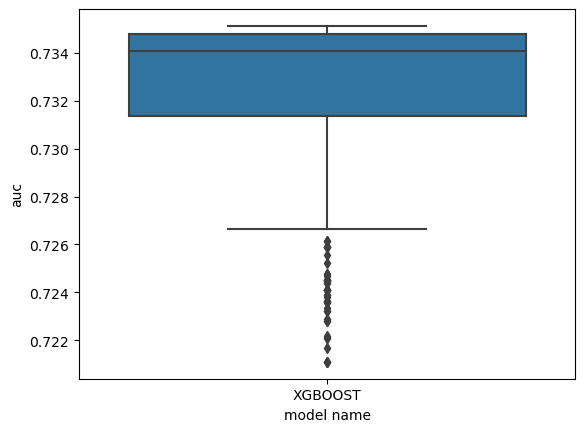

In [19]:
sns.boxplot(data=recap_hyper_opt_final, x="model name", y="auc")

#### Quelques vérifications  
Nous avons le modèle candidat, il est désormait important de vérifier deux choses :
- Vérifier que l'écart type entre les folds et faibles  
- Regarder le score sur le jeu de validation

**Ecart type entre les folds**

In [30]:
recap_hyper_opt_final.sort_values(by = 'auc').iloc[-1,:]['std_auc']

0.0020861063268788867

Nous constatons que lécart type est faible

**Regarder le score sur le jeu de validation**

In [31]:
from imblearn.under_sampling import TomekLinks

In [37]:
#data_valid  

data_train_test = data_train_test.fillna(data_train_test.median())
data_valid   = data_valid.fillna(data_train_test.median())

In [38]:
data_X = data_train_test.iloc[:,:-1]
data_y = data_train_test.iloc[:,-1]

In [44]:
data_X_valid = data_valid.iloc[:,:-1]
data_y_valid = data_valid.iloc[:,-1]

In [39]:
tl = TomekLinks()

In [40]:
X_resampled, y_resampled = tl.fit_resample(data_X, data_y)

In [41]:
model = XGBClassifier()

In [42]:
model.set_params(**final_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, min_samples_leaf=7,
              min_samples_split=3, missing=nan, monotone_constraints=None,
              n_estimators=44, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
data_train_test, data_valid

In [43]:
model.fit(data_X, data_y)


[15:18:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              min_samples_leaf=7, min_samples_split=3, missing=nan,
              monotone_constraints='()', n_estimators=44, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [45]:
y_pred_proba = model.predict_proba(data_X_valid)[:, 1]
y_pred =  model.predict(data_X_valid)
auc_ = metrics.roc_auc_score(data_y_valid, y_pred_proba)

In [46]:
auc_

0.7455067233215507

Nous arrivons donc à une performance de 0.7455 sur le jeu de validation, ce qui est très cohérent

## Fonction cout métier


Dans l'idée nous allons utiliser la métrique auroc pour détermier les meilleurs paramètres/modèles/ méthodes de sampling.
Une fois ces étape passée nous devons déterminer un seuil de probabilité pour l'attibution des classes 0 ou 1 afin de maximiser les bénéfices.  
Nous allons ici définir cette nouvelle métrique :  

- Un client bien classifié comme pouvant rembourser son crédit (TN) raporte 1 
- A l'inverse un client mal classifié comme ne pouvant pas rembourser son crédit (FP) fait perdre 1
- Un client mal classifié comme pouvant rembourser son crédit (FN) fait perdre 10
- A l'inverse un bien client classfié comme ne pouvant pas rembourser sont crédit (TP) rapporte 10

l'idée est qu'un client qui ne rembouse pas coute bien plus qu'un client ayant bien remboursé.  

Nous devrons donc maximiser la fonction suivante :  
f(p) = |TN| - |FP| + 10(|TP|-|FN|) avec p = le seuil pour attribuer la classe 1, |X| dépend directement de p

In [47]:
probs = y_pred_proba

In [48]:
def to_label(probs,t):
    result = [0 if i < t else 1 for i in probs]
    return result

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def cout_metier(probs, t, y_actual):
    y_hat = [0 if i < t else 1 for i in probs]
    TP, FP, TN, FN = perf_measure(y_actual, y_hat)
    return TN - FP + 10*(TP - FN)

In [ ]:
probs  = model.predict_proba(X_test_)[:, 1]

In [49]:

thresholds = np.arange(0, 1, 0.01)

scores = [cout_metier(probs, t, data_y_valid.values) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


Threshold=0.080, F-Score=38619.00000


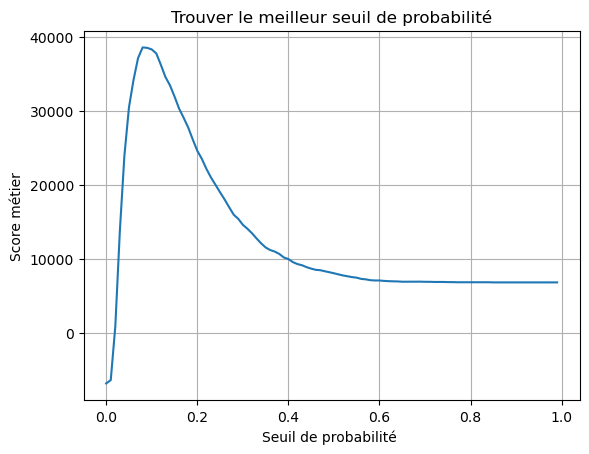

In [50]:
fig, ax = plt.subplots()
ax.plot(thresholds, scores)

ax.set(xlabel='Seuil de probabilité ', ylabel='Score métier',
       title='Trouver le meilleur seuil de probabilité')
ax.grid()

fig.savefig("test.png")
plt.show()

Nous trouvons que le seuil optimal se situe à **0.08**

#### Cross table

Nous voulons savoir l'influance de ce seuil sur la détection des vrais positifs.  

**En utilisant le seuil par défault de 0.5**

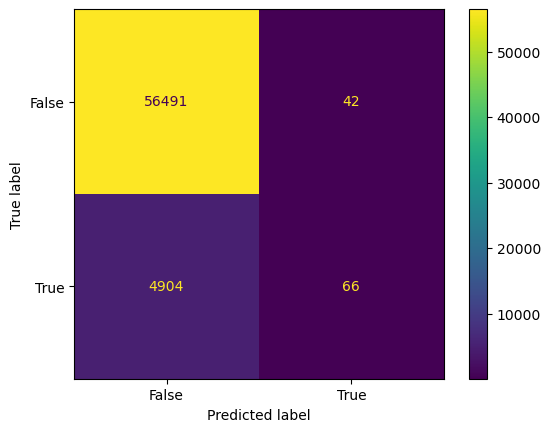

In [52]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = data_y_valid
predicted = y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

**En utilisant le seuil optimal de 0.08** 

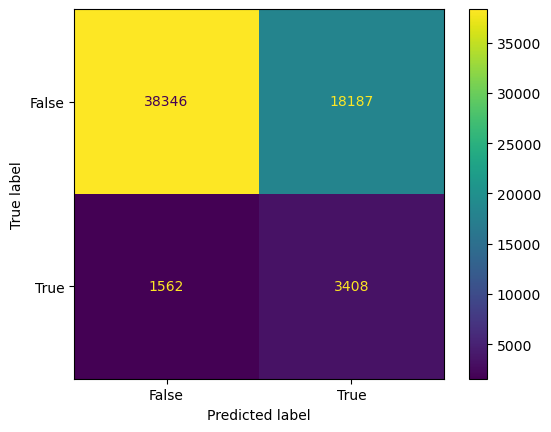

In [55]:
y_pred_metier = to_label(probs,0.08)
actual = data_y_valid
predicted = y_pred_metier

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()    

Comme attendu le taux de vrais positifs à considérablement augmenté

## Interprétabilité du modèle

- Nous volons donner la possibilité d'avoir une idée du fonctionnement global de notre modèle. Ces analyse permettent de comprendre quels sont les facteurs qui influent le plus en faveur ou défaveur de l'optention du prêt. Ne pas avoir une simple "boite noire" qui nous dicte ce que l'on doit penser

- Il est très pertinent de pouvoir donner une explication aux clients des raisons du refus afin qu'ils puissent s'améliorer et éventuellement tenter leur chance ultérieurement.

La librairie **Shap** va nous permettre d'apporter des solution à ces problématiques 

#### Entrainement du modèle final

In [77]:
data_train_test.iloc[:,:-1]

BURO_DAYS_CREDIT_MAX  NAME_INCOME_TYPE_Pensioner  \
SK_ID_CURR                                                     
277977                    -252.0                           0   
137442                   -1033.0                           1   
335600                     -92.0                           1   
406929                     -39.0                           0   
177779                    -223.0                           0   
...                          ...                         ...   
124980                    -742.0                           0   
236346                   -2699.0                           0   
185050                    -762.0                           0   
409734                       0.0                           0   
248507                     -68.0                           0   

            PREV_NAME_YIELD_GROUP_XNA_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                 
277977                            0.444444                   -222.400000   
137442                            0.333333                  -1532.666667   
335600                            0.000000                   -563.578947   
406929                            0.555556                   -700.750000   
177779                            0.666667                   -175.333333   
...                                    ...                           ...   
124980                            0.500000                   -533.857143   
236346                            0.400000                  -2079.000000   
185050                            0.000000                   -370.000000   
409734                            0.333333                      0.000000   
248507                            0.666667                   -494.500000   

            BURO_DAYS_CREDIT_MEAN  CLOSED_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                          
277977                -558.800000                     -356.666667   
137442               -1915.555556                    -1551.000000   
335600               -1063.368421                     -949.909091   
406929                -897.375000                     -787.384615   
177779                -319.333333                     -257.500000   
...                           ...                             ...   
124980               -1133.714286                     -956.000000   
236346               -2699.000000                    -2079.000000   
185050               -1163.500000                     -719.000000   
409734                   0.000000                        0.000000   
248507                -856.250000                     -647.666667   

            BURO_CREDIT_ACTIVE_Closed_MEAN  EXT_SOURCE_3  \
SK_ID_CURR                                                 
277977                            0.600000      0.484851   
137442                            0.666667      0.537070   
335600                            0.578947      0.406617   
406929                            0.812500      0.282248   
177779                            0.666667      0.230159   
...                                    ...           ...   
124980                            0.428571      0.546023   
236346                            1.000000      0.537070   
185050                            0.500000      0.751724   
409734                            0.000000      0.778904   
248507                            0.750000      0.619528   

            PREV_CODE_REJECT_REASON_HC_MEAN  EXT_SOURCE_2  ...  DAYS_EMPLOYED  \
SK_ID_CURR                                                 ...                  
277977                             0.111111      0.501472  ...         -203.0   
137442                             0.000000      0.643068  ...            0.0   
335600                             0.000000      0.634404  ...            0.0   
406929                             0.000000      0.410203  ...        -1654.0   
177779                   

In [71]:
data_train = data_train.fillna(data_train.median())
data_X = data_train_test.iloc[:,:-1].values
data_y = data_train_test.iloc[:,-1].values
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(data_X, data_y)
model = XGBClassifier()
model.set_params(**final_params)
model.fit(data_X, data_y)

[18:23:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              min_samples_leaf=7, min_samples_split=3, missing=nan,
              monotone_constraints='()', n_estimators=44, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [74]:
import pickle
filename = "model1.pkl"
pickle.dump(model, open(filename, 'wb'))

In [41]:
data_no_label = data_full[data_full['TARGET'].isna()]
data_no_label.fillna(value = 0, inplace = True)
test_X = data_no_label.drop(columns = 'TARGET')
test_y = data_no_label['TARGET']

In [98]:
data_train_test_shap = data_train_test[1]

BURO_DAYS_CREDIT_MAX  NAME_INCOME_TYPE_Pensioner  \
SK_ID_CURR                                                     
277977                    -252.0                           0   
137442                   -1033.0                           1   
335600                     -92.0                           1   
406929                     -39.0                           0   
177779                    -223.0                           0   
...                          ...                         ...   
124980                    -742.0                           0   
236346                   -2699.0                           0   
185050                    -762.0                           0   
409734                       0.0                           0   
248507                     -68.0                           0   

            PREV_NAME_YIELD_GROUP_XNA_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                 
277977                            0.444444                   -222.400000   
137442                            0.333333                  -1532.666667   
335600                            0.000000                   -563.578947   
406929                            0.555556                   -700.750000   
177779                            0.666667                   -175.333333   
...                                    ...                           ...   
124980                            0.500000                   -533.857143   
236346                            0.400000                  -2079.000000   
185050                            0.000000                   -370.000000   
409734                            0.333333                      0.000000   
248507                            0.666667                   -494.500000   

            BURO_DAYS_CREDIT_MEAN  CLOSED_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                          
277977                -558.800000                     -356.666667   
137442               -1915.555556                    -1551.000000   
335600               -1063.368421                     -949.909091   
406929                -897.375000                     -787.384615   
177779                -319.333333                     -257.500000   
...                           ...                             ...   
124980               -1133.714286                     -956.000000   
236346               -2699.000000                    -2079.000000   
185050               -1163.500000                     -719.000000   
409734                   0.000000                        0.000000   
248507                -856.250000                     -647.666667   

            BURO_CREDIT_ACTIVE_Closed_MEAN  EXT_SOURCE_3  \
SK_ID_CURR                                                 
277977                            0.600000      0.484851   
137442                            0.666667      0.537070   
335600                            0.578947      0.406617   
406929                            0.812500      0.282248   
177779                            0.666667      0.230159   
...                                    ...           ...   
124980                            0.428571      0.546023   
236346                            1.000000      0.537070   
185050                            0.500000      0.751724   
409734                            0.000000      0.778904   
248507                            0.750000      0.619528   

            PREV_CODE_REJECT_REASON_HC_MEAN  EXT_SOURCE_2  ...  \
SK_ID_CURR                                                 ...   
277977                             0.111111      0.501472  ...   
137442                             0.000000      0.643068  ...   
335600                             0.000000      0.634404  ...   
406929                             0.000000      0.410203  ...   
177779                             0.000000      0.396066  ...   
...                                     ...      

In [100]:
data_train_test.iloc[:,:-1].sample(100)

BURO_DAYS_CREDIT_MAX  NAME_INCOME_TYPE_Pensioner  \
SK_ID_CURR                                                     
435889                    -436.0                           1   
429119                    -676.0                           0   
172174                   -2326.0                           0   
330655                    -100.0                           0   
135192                    -485.0                           0   
...                          ...                         ...   
345633                    -628.0                           0   
269441                    -244.0                           0   
326243                   -2210.0                           0   
439521                       0.0                           0   
115000                    -184.0                           0   

            PREV_NAME_YIELD_GROUP_XNA_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                                 
435889                            0.000000                   -582.600000   
429119                            0.250000                     -5.000000   
172174                            0.400000                  -1954.000000   
330655                            0.500000                   -370.888889   
135192                            0.000000                   -320.750000   
...                                    ...                           ...   
345633                            0.000000                   -735.750000   
269441                            0.428571                   -388.125000   
326243                            0.000000                   -726.000000   
439521                            0.200000                      0.000000   
115000                            0.142857                   -900.571429   

            BURO_DAYS_CREDIT_MEAN  CLOSED_DAYS_CREDIT_UPDATE_MEAN  \
SK_ID_CURR                                                          
435889               -1067.800000                    -1009.600000   
429119                -676.000000                        0.000000   
172174               -2423.000000                    -1954.000000   
330655                -742.666667                     -659.800000   
135192                -808.500000                     -616.500000   
...                           ...                             ...   
345633               -1213.875000                     -707.428571   
269441               -1074.500000                     -606.600000   
326243               -2219.500000                     -668.000000   
439521                   0.000000                        0.000000   
115000               -1684.142857                    -1252.000000   

            BURO_CREDIT_ACTIVE_Closed_MEAN  EXT_SOURCE_3  \
SK_ID_CURR                                                 
435889                            0.500000      0.212756   
429119                            0.000000      0.733815   
172174                            1.000000      0.537070   
330655                            0.555556      0.380800   
135192                            0.500000      0.576209   
...                                    ...           ...   
345633                            0.875000      0.719491   
269441                            0.625000      0.670652   
326243                            0.500000      0.812823   
439521                            0.000000      0.537070   
115000                            0.714286      0.526295   

            PREV_CODE_REJECT_REASON_HC_MEAN  EXT_SOURCE_2  ...  \
SK_ID_CURR                                                 ...   
435889                                  0.0      0.451370  ...   
429119                                  0.0      0.022637  ...   
172174                                  0.0      0.574060  ...   
330655                                  0.0      0.624033  ...   
135192                                  0.0      0.738624  ...   
...                                     ...      

In [79]:
import shap

In [106]:
data_sample = data_train_test.iloc[:,:-1].sample(10000)

In [107]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_train_test.iloc[:,:-1])

In [108]:
shap_values = explainer(data_sample)

### Interprétabilité globale

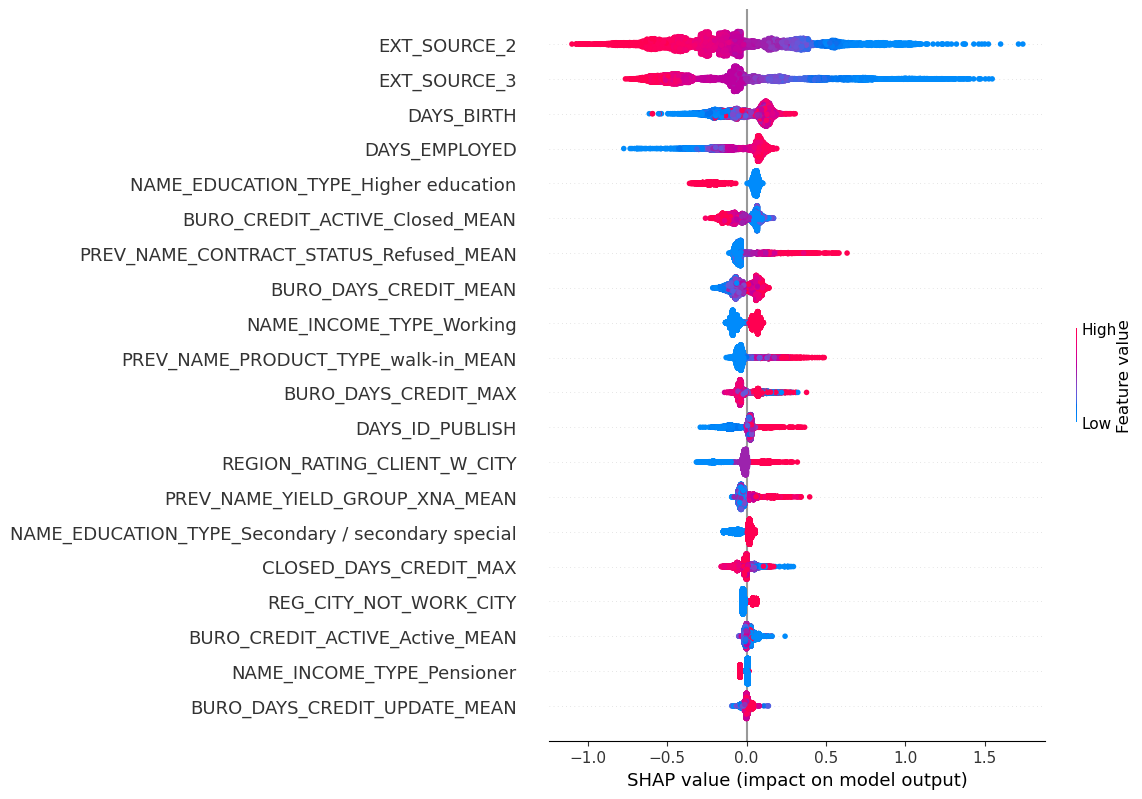

In [109]:
shap.summary_plot(shap_values, data_sample)

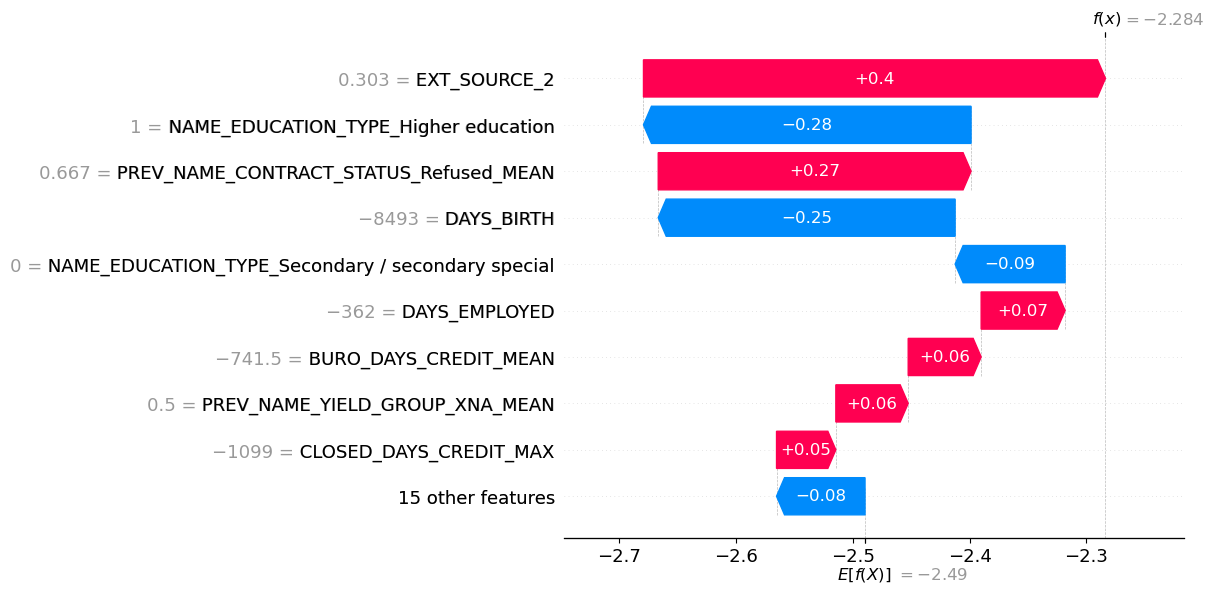

In [110]:
shap.plots.waterfall(shap_values[2])